In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load your data
data = pd.read_excel("Companies_transpose_edited_2_final.xlsx")
df = pd.DataFrame(data)
df

,Company,Country,Ticker,Year,Revenue,Net Income/Net Profit (Losses),Total Assets,Current Market Cap,Volume,EBITDA,...,Inflation_Rate,Real_GDP_Growth_Rate,ESG_Committee,International_presence,Years in Market,ESG Risk Rating,Moodys Credit Rating,Developed,Market Cap to EBITDA,R&D expense
0,Kinnevik AB,Sweden,KINVB SS,2022,1914.4811,-1935.503,5543.0201,3855.4092,233189101,—,...,8.60,2.663,1.0,1.0,84.0,7.663,Baa2,1.0,NaN,30.0
1,GoTo Gojek Tokopedia Tbk PT,Indonesia,GOTO IJ,2023,970.7858,-5935.196,3514.6346,6712.6579,1202357465,-499.5144,...,3.68,5.048,1.0,1.0,10.0,17.300,Caa1,0.0,-13.438367,NaN
2,EagleView Technology Corporation,USA,LEI US,2022,0.5973,-107.742,34.6967,2.767452,69188000,-4.3685,...,8.00,2.100,0.0,1.0,20.0,21.000,Caa2,1.0,-633.501684,200.0
3,Atos SE,France,ALTAO FP,2022,0.45,-0.5936,1.62826,1.81202,259526497,-0.6037,...,5.90,2.526,1.0,1.0,54.0,16.975,Ba2,1.0,-3.001524,1400.0
4,EagleView Technology Corporation,USA,LEI US,2021,0.4012,-169.6752,4.64041,9.258363,23145000,-5.4211,...,4.70,5.900,0.0,1.0,19.0,22.000,Caa2,1.0,-170.783838,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,"Cloudera, Inc.",USA,CLDR UN,2019,479.941,-192.649,2196.643,3584.4766,144131970,-176.336,...,1.80,2.300,0.0,1.0,11.0,29.000,B3,1.0,-20.327537,250.0
638,"Cloudera, Inc.",USA,CLDR UN,2020,794.191,-336.582,2299.79,2954.7889,299390910,-217.688,...,1.20,-3.500,0.0,1.0,12.0,28.000,B3,1.0,-13.573504,300.0
639,"Cloudera, Inc.",USA,CLDR UN,2021,869.258,-162.734,2508.601,4775.765,275932932,-35.855,...,4.70,5.900,0.0,1.0,13.0,27.000,B3,1.0,-133.196625,350.0
640,"Cloudera, Inc.",USA,CLDR UN,2022,869.258,0,1939.21125,3489.7292,275932932,-197.98725,...,8.00,2.100,0.0,1.0,14.0,26.000,B3,1.0,-17.626030,400.0


In [3]:
# --- Keep your original data info code for reference ---
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Company                                642 non-null    object 
 1   Country                                642 non-null    object 
 2   Ticker                                 642 non-null    object 
 3   Year                                   642 non-null    int64  
 4   Revenue                                639 non-null    object 
 5   Net Income/Net Profit (Losses)         639 non-null    object 
 6   Total Assets                           639 non-null    object 
 7   Current Market Cap                     638 non-null    object 
 8   Volume                                 639 non-null    object 
 9   EBITDA                                 639 non-null    object 
 10  Net Debt                               639 non-null    object 
 11  Total 

In [4]:
print(df.describe(include='all'))

            Company Country    Ticker         Year Revenue  \
count           642     642       642   642.000000     639   
unique          107      24       112          NaN     628   
top     Kinnevik AB     USA  KINVB SS          NaN       —   
freq              6     162         6          NaN       3   
mean            NaN     NaN       NaN  2020.500000     NaN   
std             NaN     NaN       NaN     1.709157     NaN   
min             NaN     NaN       NaN  2018.000000     NaN   
25%             NaN     NaN       NaN  2019.000000     NaN   
50%             NaN     NaN       NaN  2020.500000     NaN   
75%             NaN     NaN       NaN  2022.000000     NaN   
max             NaN     NaN       NaN  2023.000000     NaN   

        Net Income/Net Profit (Losses) Total Assets Current Market Cap Volume  \
count                            639.0          639                638    639   
unique                           629.0          631                617    600   
top         

In [5]:
# --- 2. Definir tipos de datos por columna ---
columns_types = {
    # Strings
    'Company': str,
    'Country': str,
    'Ticker': str,
    'Moodys Credit Rating': str,
    
    # Integers
    'Year': 'Int64',
    'Years in Market': 'Int64',
    'Volume': 'Int64',
    'ESG_Committee': 'Int64',
    'Developed': 'Int64',
    'International_presence': 'Int64',
    
    # Floats
    'Revenue': float,
    'Net Income/Net Profit (Losses)': float,
    'Total Assets': float,
    'Current Market Cap': float,
    'EBITDA': float,
    'Net Debt': float,
    'Total Equity': float,
    'ROIC': float,
    'EBIT': float,
    'Net interest': float,
    'CAPEX': float,
    'Total Liabilities': float,
    'Total Debt': float,
    'Quick ratio': float,
    'Cash and equiv': float,
    'Mkt securities': float,
    'Asset Turnover': float,
    'Net marging': float,
    'Debt/Equity': float,
    'Log(Total Assets)': float,
    'Ln(revenue)': float,
    'ROE': float,
    '(EBIT-CapEx)/Interest Expense': float,
    'ROA': float,
    'Debt to EBITDA': float,
    'Debt Ratio': float,
    'Debt/Book Capitalization': float,
    'Debt/Equity Ratio': float,
    'Debt/Total Capitalization': float,
    '(Cash + Marketable Securities) / Debt': float,
    'Market Cap to Revenue ratio': float,
    '(P/B) ratio': float,
    'GDP_per_Capita': float,
    'Inflation_Rate': float,
    'Real_GDP_Growth_Rate': float,
    'ESG Risk Rating': float,
    'Market Cap to EBITDA': float,
    'R&D expense': float,
}

# --- 3. Reemplazar coma decimal si aplica ---
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)

# --- 4. Convertir columnas a sus tipos correspondientes ---
for col, dtype in columns_types.items():
    try:
        # Conversión directa sin verificar 'boolean'
        df[col] = pd.to_numeric(df[col], errors='coerce') if dtype in [float, 'Int64'] else df[col].astype(dtype)
    except Exception as e:
        print(f"Error converting column {col}: {e}")

# --- 5. Verifica los resultados ---
print(df.dtypes)
print(df.head())

Company                                   object
Country                                   object
Ticker                                    object
Year                                       int64
Revenue                                  float64
Net Income/Net Profit (Losses)           float64
Total Assets                             float64
Current Market Cap                       float64
Volume                                   float64
EBITDA                                   float64
Net Debt                                 float64
Total Equity                             float64
ROIC                                     float64
EBIT                                     float64
Net interest                             float64
CAPEX                                    float64
Total Liabilities                        float64
Total Debt                               float64
Quick ratio                              float64
Cash and equiv                           float64
Mkt securities      

In [6]:
# Filtrar las variables importantes
important_variables = [
    'Revenue', 'Net Income/Net Profit (Losses)', 'Total Assets', 'Current Market Cap', 'Volume',
    'EBITDA', 'Net Debt', 'Total Equity', 'ROIC', 'EBIT', 'Net interest', 'CAPEX', 'Total Liabilities',
    'Total Debt', 'Quick ratio', 'Cash and equiv', 'Mkt securities', 'Asset Turnover', 'Net marging',
    'Debt/Equity', 'Log(Total Assets)', 'Ln(revenue)', 'ROE', '(EBIT-CapEx)/Interest Expense',
    'ROA', 'Debt to EBITDA', 'Debt Ratio', 'Debt/Book Capitalization', 'Debt/Equity Ratio',
    'Debt/Total Capitalization', '(Cash + Marketable Securities) / Debt', 'Market Cap to Revenue ratio',
    '(P/B) ratio', 'Market Cap to EBITDA', 'R&D expense', 'GDP_per_Capita', 'Inflation_Rate',
    'Real_GDP_Growth_Rate', 'ESG_Committee', 'International_presence', 'Years in Market',
    'ESG Risk Rating', 'Moodys Credit Rating', 'Developed'
]

# Obtener la descripción de las variables importantes
description = df[important_variables].describe(include='all')

# Transponer la tabla
description_transposed = description.T

# Opcional: Renombrar las columnas para mayor claridad
description_transposed = description_transposed.rename(columns={
    'count': 'Number of observations',
    'mean': 'Mean',
    'std': 'Standard deviation',
    'min': 'Minimum',
    '25%': '25th Percentile',
    '50%': 'Median',
    '75%': '75th Percentile',
    'max': 'Maximum',
    'unique': 'Unique values',
    'top': 'Most frequent value',
    'freq': 'Frequency of most common value'
})

# Guardar la tabla transpuesta en un nuevo CSV
description_transposed.to_csv('description_important_variables_transposed.csv')

# Mostrar la tabla transpuesta
description_df = pd.DataFrame(description_transposed)
description_df

,Number of observations,Unique values,Most frequent value,Frequency of most common value,Mean,Standard deviation,Minimum,25th Percentile,Median,75th Percentile,Maximum
Revenue,636.0,NaN,NaN,NaN,27750.02276,63727.629471,0.0,1439.05615,5957.9184,22617.75,574785.0
Net Income/Net Profit (Losses),636.0,NaN,NaN,NaN,3674.52167,11932.944656,-22355.0,-1.490725,334.2107,1867.937,99803.0
Total Assets,636.0,NaN,NaN,NaN,45055.875594,83894.756831,1.1407,2899.264025,10979.8453,37409.005225,527854.0
Current Market Cap,622.0,NaN,NaN,NaN,109773.233344,325049.444061,0.0,3324.863125,17760.42225,49018.6575,2676736.8607
Volume,609.0,NaN,NaN,NaN,2720499052.232517,6484894562.855348,0.0,95161684.0,635568599.0,2648397900.0,94583088490.0
EBITDA,630.0,NaN,NaN,NaN,6528.219961,17533.320711,-9207.0,90.1474,909.426,3790.4249,132441.0
Net Debt,636.0,NaN,NaN,NaN,-2433.732978,19346.033664,-122617.0,-1560.18825,7.45054,2291.788225,84946.0
Total Equity,636.0,NaN,NaN,NaN,20234.813712,43118.803991,-6294.0,1394.172775,5040.5225,14635.916,283379.0
ROIC,628.0,NaN,NaN,NaN,3.985809,25.945264,-187.0444,0.876525,7.01265,13.425625,227.2008
EBIT,636.0,NaN,NaN,NaN,4272.197867,13632.123392,-15789.0,5.147275,478.6591,2349.674875,119437.0


In [7]:
# Rename columns to be compatible with patsy formula syntax
df.columns = [col.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace('-', '_').replace('+', 'plus').replace('&', 'and').replace('__', '_') for col in df.columns]


1. Distribution Plots (Numerical Variables)

Insights: Shows how financial health metrics differ between investment grade (1) and junk (0) ratings.

1. Missing Data Heatmap

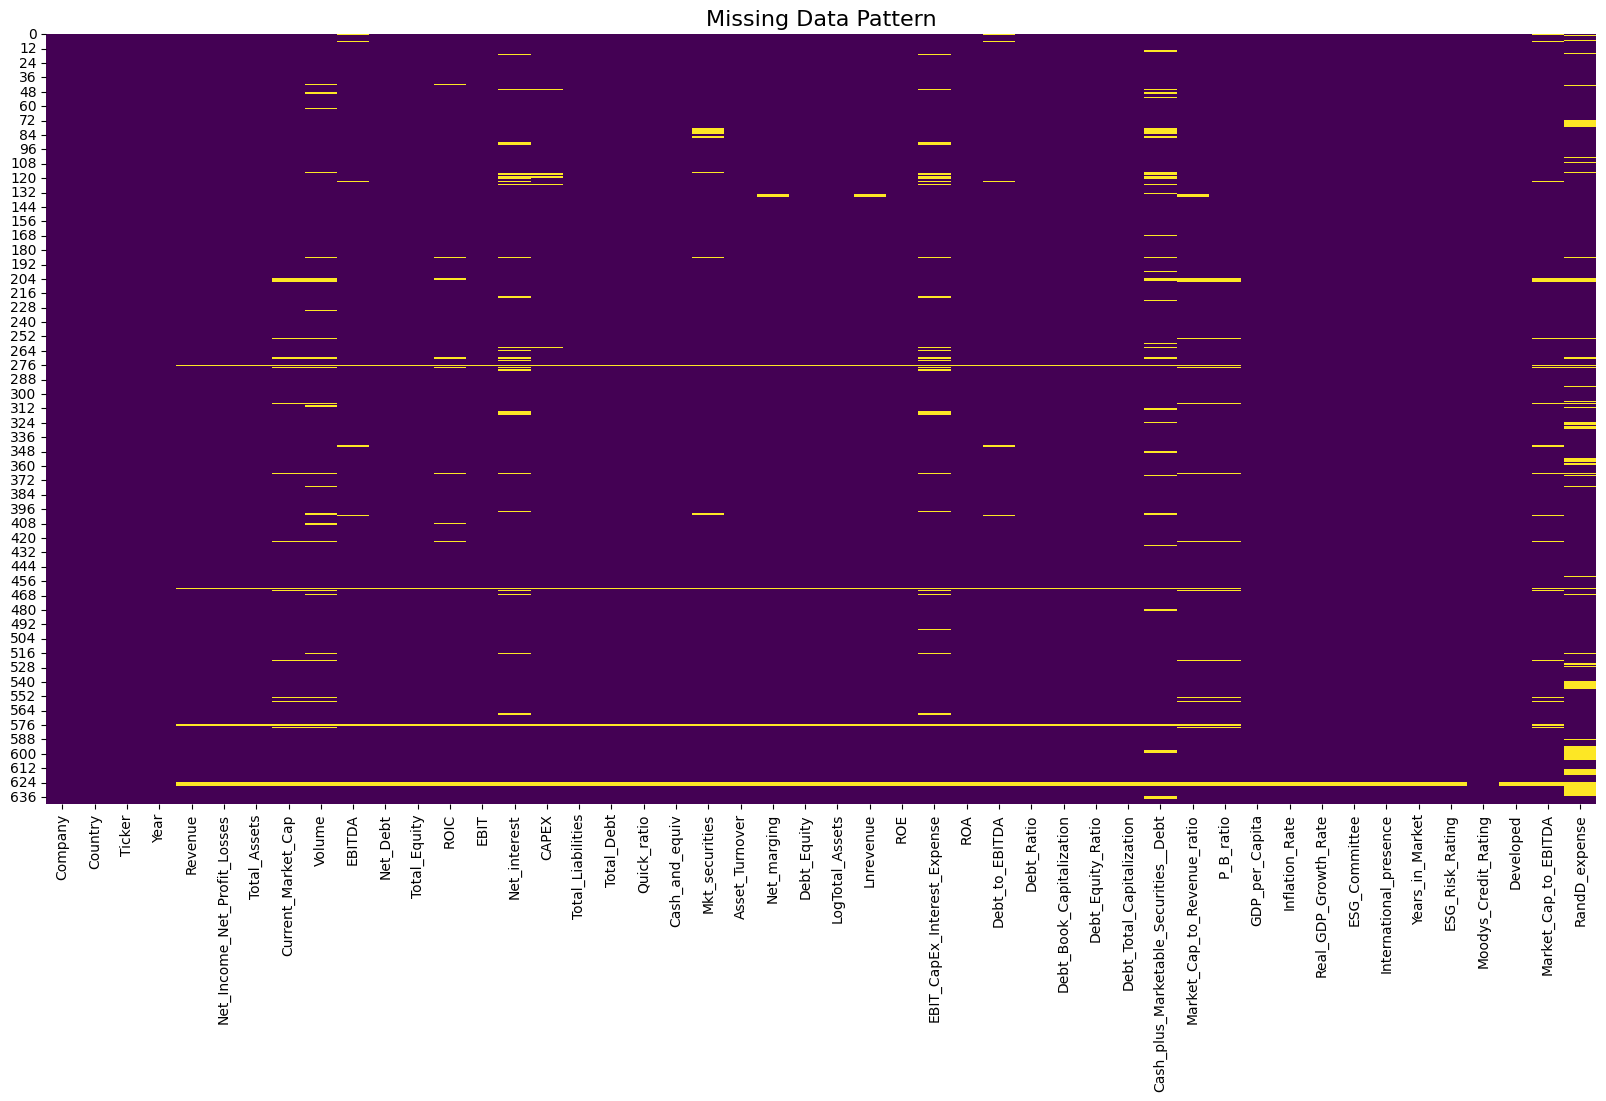

In [8]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Pattern', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [9]:
print(df["Country"].nunique())

24


2. Numerical Variables Distribution

Purpose: Spot outliers and understand data distributions before cleaning.


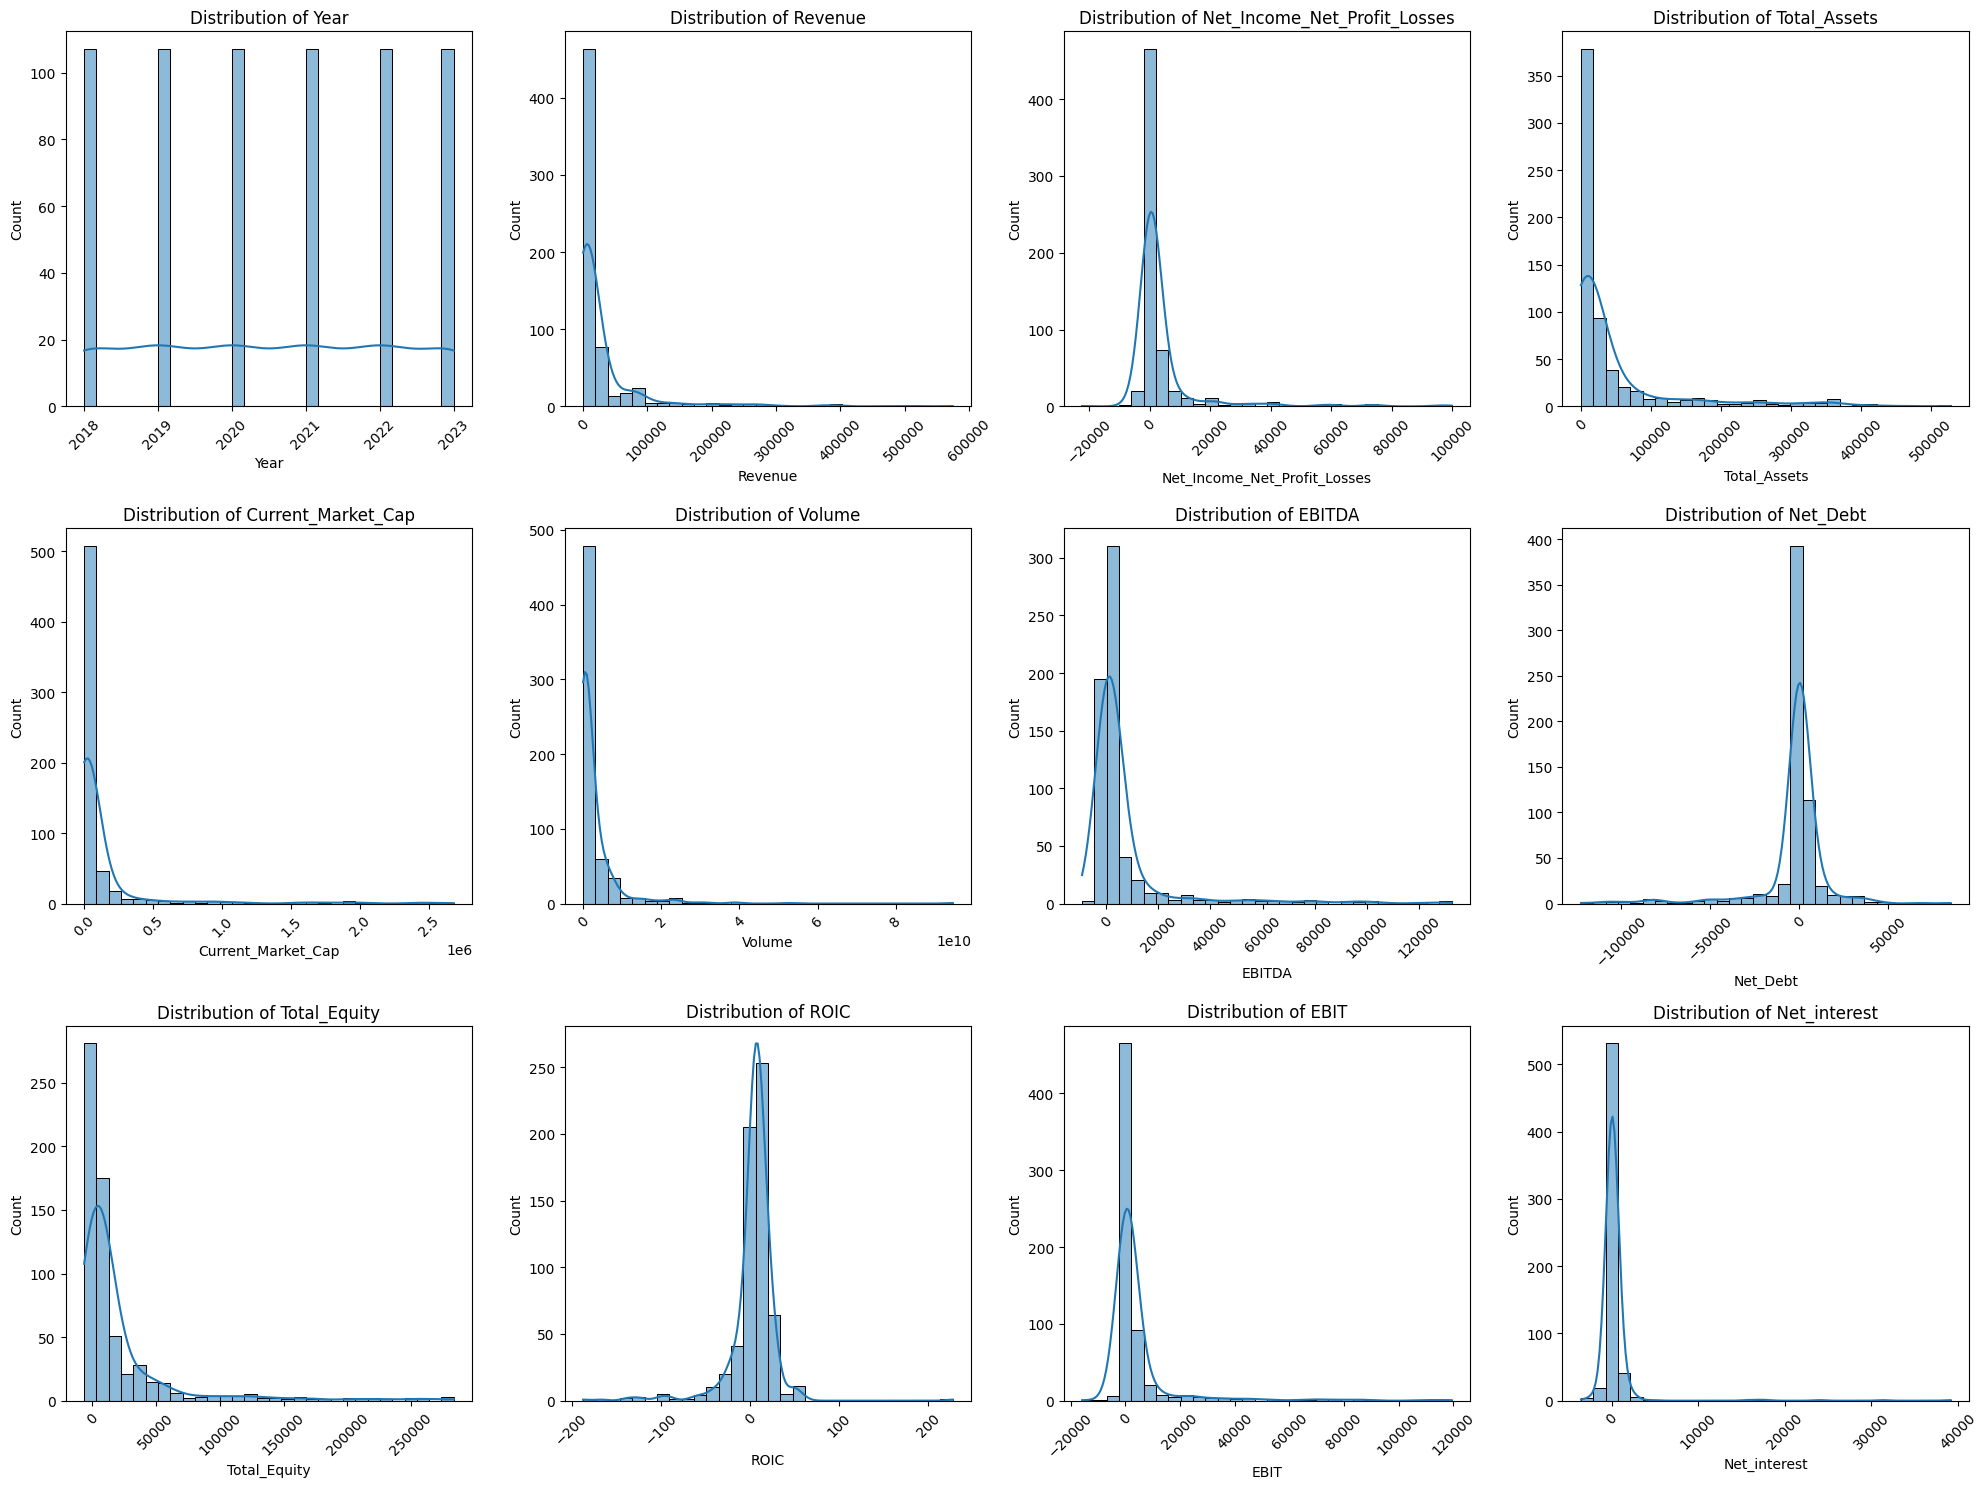

In [10]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(num_cols[:12], 1):  # First 12 numerical columns
    plt.subplot(3, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


3. Categorical Variables Analysis


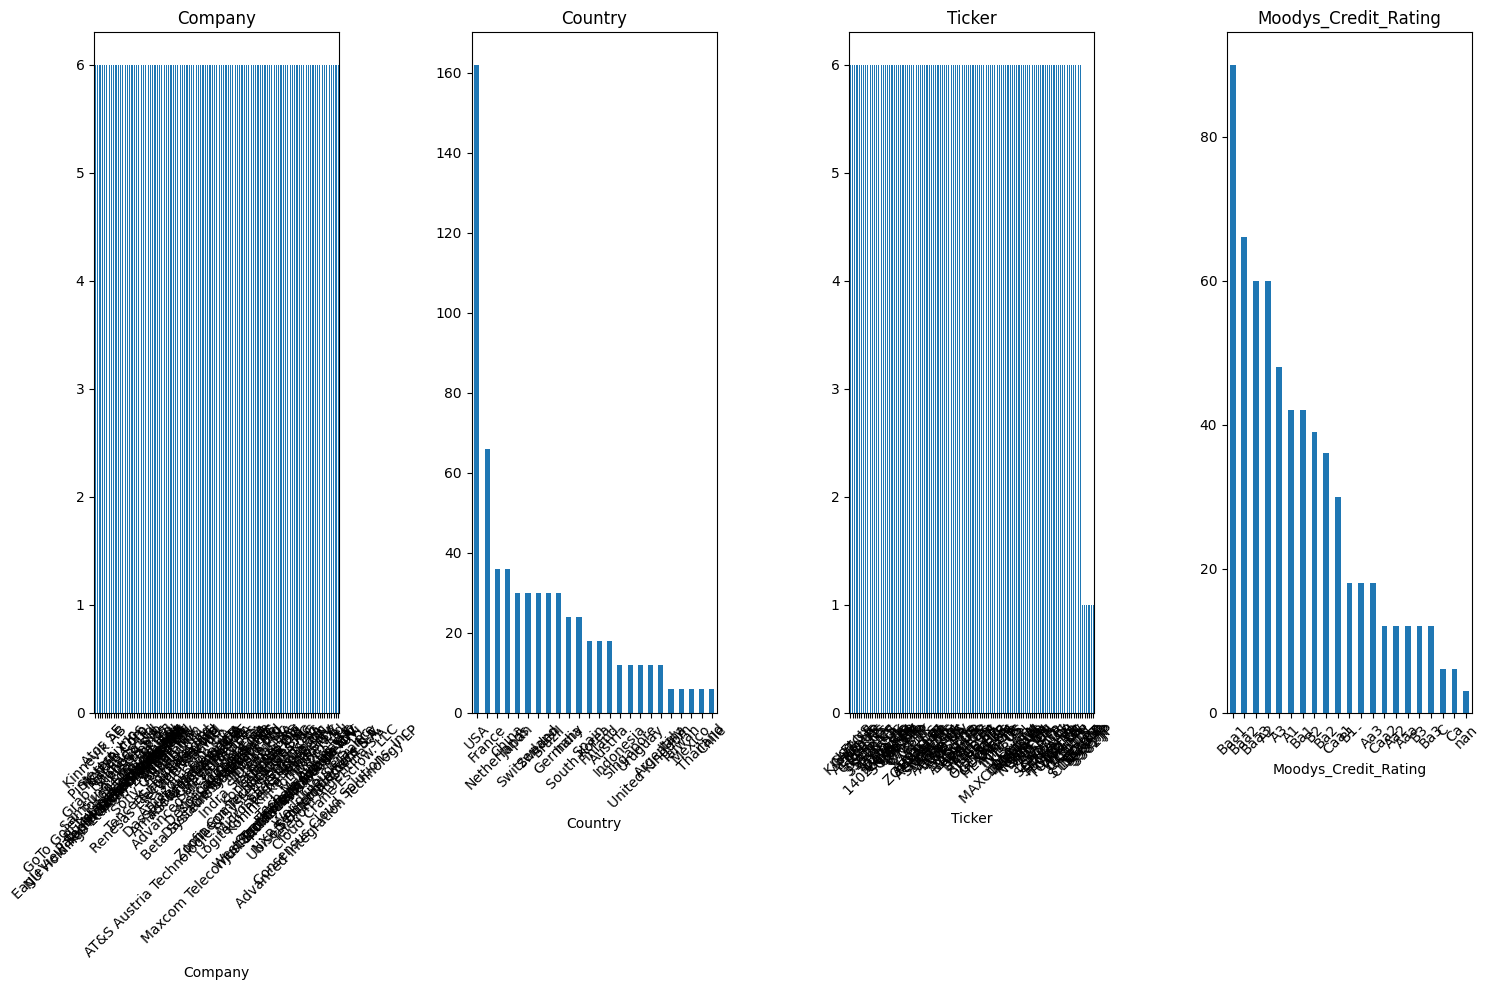

In [11]:
# Select categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Check if there are any categorical columns to plot
if len(cat_cols) == 0:
    print("No categorical columns found in the DataFrame.")
else:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(cat_cols, 1):
        plt.subplot(1, len(cat_cols), i)
        df[col].value_counts().plot(kind='bar')
        plt.title(col)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()  # Ensure this is called to display the plots

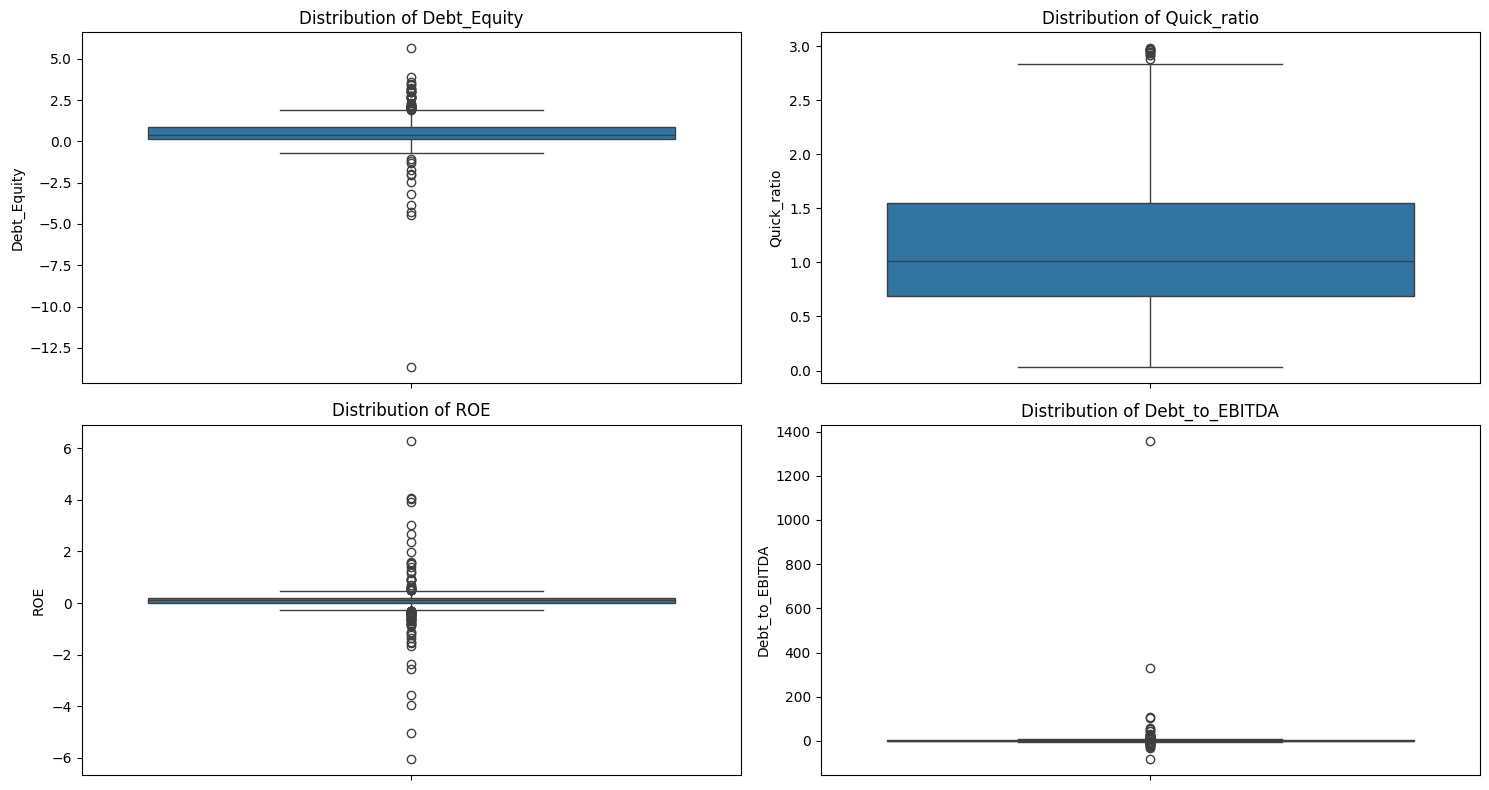

In [12]:
ratios = ['Debt_Equity', 'Quick_ratio', 'ROE', 'Debt_to_EBITDA']

plt.figure(figsize=(15, 8))
for i, col in enumerate(ratios, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

5. Time Series Analysis (by Year)


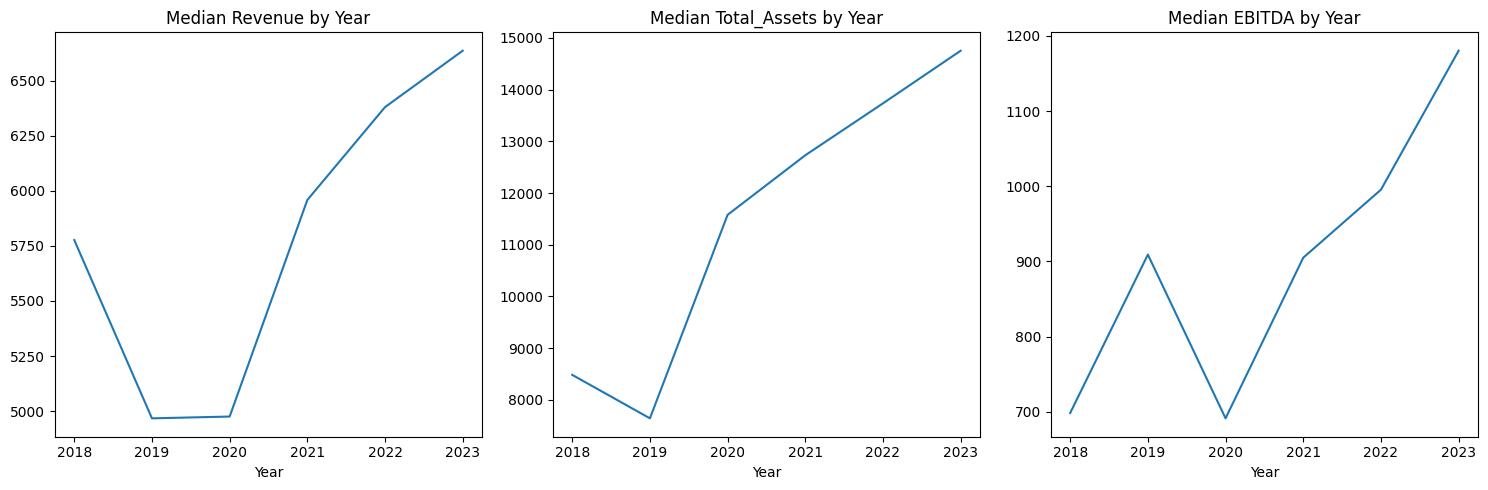

In [13]:
if 'Year' in df.columns:
    metrics = ['Revenue', 'Total_Assets', 'EBITDA']
    
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        df.groupby('Year')[col].median().plot()
        plt.title(f'Median {col} by Year')
    plt.tight_layout()
    plt.show()

6. Correlation Matrix (Numerical Variables)


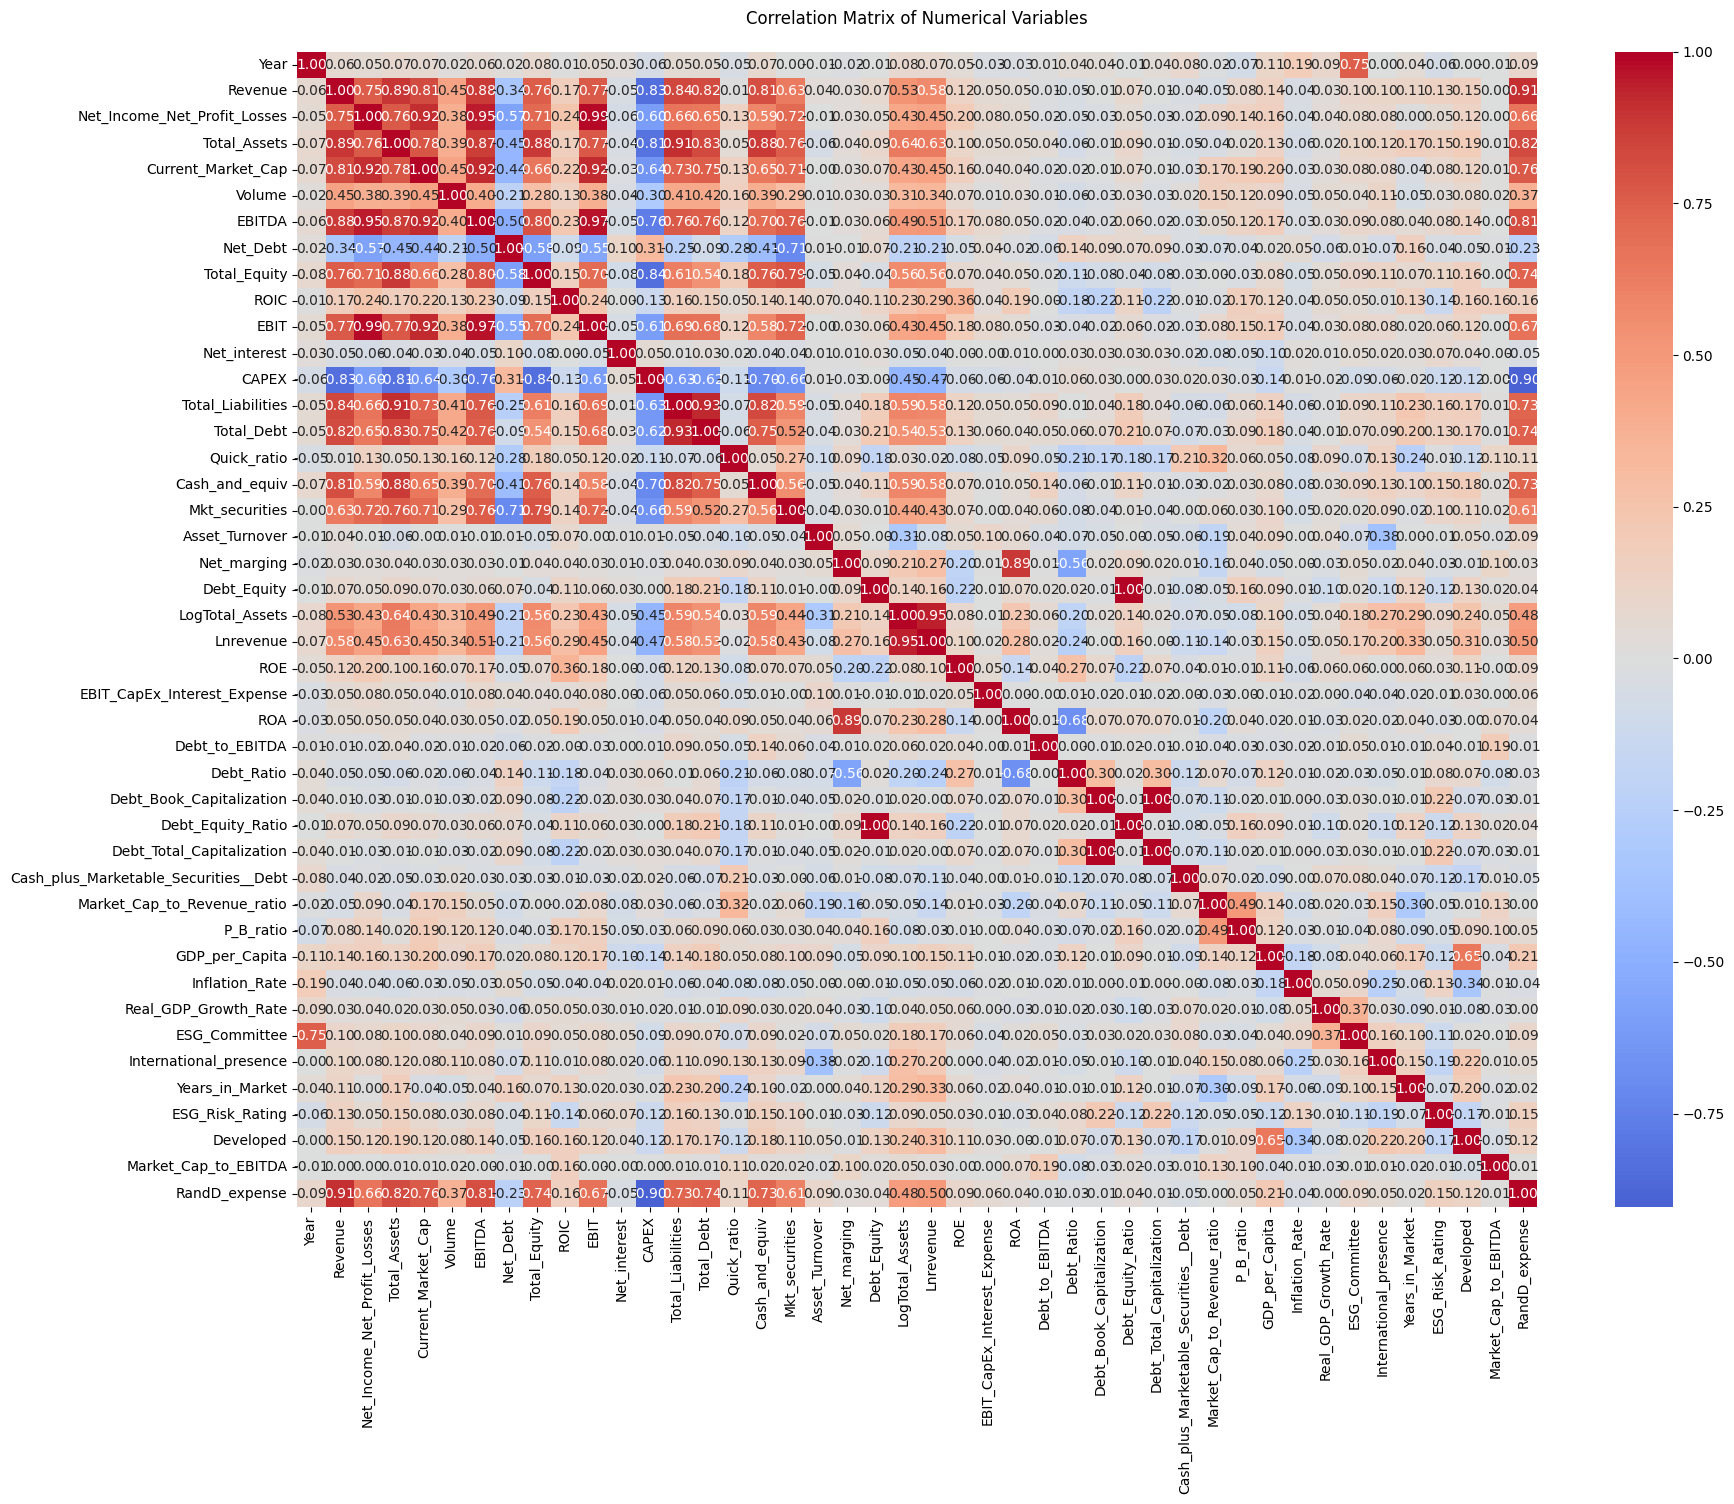

In [14]:
plt.figure(figsize=(20, 15))
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables', pad=20)
plt.show()

8. Target Variable Analysis


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Company                                642 non-null    object 
 1   Country                                642 non-null    object 
 2   Ticker                                 642 non-null    object 
 3   Year                                   642 non-null    int64  
 4   Revenue                                636 non-null    float64
 5   Net_Income_Net_Profit_Losses           636 non-null    float64
 6   Total_Assets                           636 non-null    float64
 7   Current_Market_Cap                     622 non-null    float64
 8   Volume                                 609 non-null    float64
 9   EBITDA                                 630 non-null    float64
 10  Net_Debt                               636 non-null    float64
 11  Total_

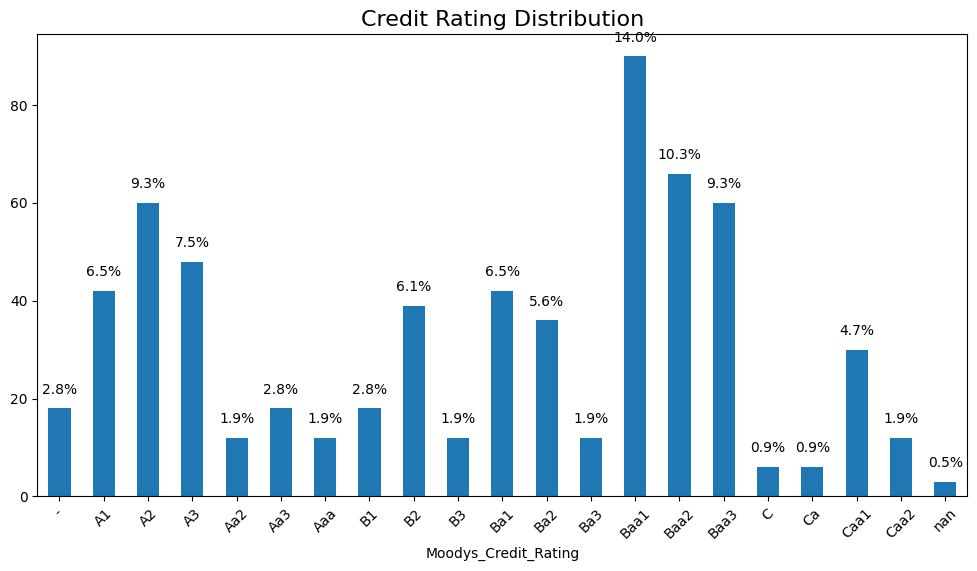

In [16]:
if 'Moodys_Credit_Rating' in df.columns:
    plt.figure(figsize=(12, 6))
    ax = df['Moodys_Credit_Rating'].value_counts().sort_index().plot(kind='bar')
    plt.title('Credit Rating Distribution', fontsize=16)
    plt.xticks(rotation=45)
    
    # Add percentage labels
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 3,
                f'{height/total:.1%}', ha='center')
    plt.show()

In [17]:

# Lista de calificaciones de Moody's
moodys_ratings = ['Aa3', 'Ba1', 'Ba2', 'Baa2', 'Aa2', 'Baa1', 'Baa3', 'Caa1', 'A3', 'A1', 'Aaa', 'A2', 'B2', 'B1', 'B3', 'Ba3']

# Definir las categorías
investment_grade = ['Aaa', 'Aa1', 'Aa2', 'Aa3', 'A1', 'A2', 'A3', 'Baa1', 'Baa2', 'Baa3','Ba1', 'Ba2', 'Ba3', 'B1']
junk = ['B2', 'B3', 'Caa1', 'Caa2', 'Caa3', 'Ca', 'C']

# Función para clasificar las calificaciones
def classify_rating(rating):
    if rating in investment_grade:
        return 1 #Investment Grade
    else:  #Todo lo demás (incluyendo Unknown) será Junk
        return 0 #Junk

# Aplicar la función al DataFrame
df['Moodys_Credit_Rating_Category'] = df['Moodys_Credit_Rating'].apply(classify_rating)

# Verificar los resultados
print(df.head())
print(df['Moodys_Credit_Rating_Category'].value_counts())

                            Company    Country    Ticker  Year    Revenue  \
0                       Kinnevik AB     Sweden  KINVB SS  2022  1914.4811   
1       GoTo Gojek Tokopedia Tbk PT  Indonesia   GOTO IJ  2023   970.7858   
2  EagleView Technology Corporation        USA    LEI US  2022     0.5973   
3                           Atos SE     France  ALTAO FP  2022     0.4500   
4  EagleView Technology Corporation        USA    LEI US  2021     0.4012   

   Net_Income_Net_Profit_Losses  Total_Assets  Current_Market_Cap  \
0                    -1935.5030    5543.02010         3855.409200   
1                    -5935.1960    3514.63460         6712.657900   
2                     -107.7420      34.69670            2.767452   
3                       -0.5936       1.62826            1.812020   
4                     -169.6752       4.64041            9.258363   

         Volume    EBITDA  ...  Real_GDP_Growth_Rate  ESG_Committee  \
0  2.331891e+08       NaN  ...                 2.66

In [18]:

# Drop rows with any missing values
df = df.dropna()

""" from scipy.stats import zscore

#Handeling missing values
for col in ['Volume', 'EBIT', 'ROE']:
    df[col] = df[col].fillna(df[col].median())
    
    # Imputation with median for numerical variables
for col in ['Revenue', 'Net Income', 'Total Assets', 'EBITDA', 'Net Debt', 'Total Equity', 'ROIC', 'EBIT', 'Net Interest', 'CAPEX', 'Total Liabilities', 'Total Debt', 'Quick Ratio', 'Cash and Equivalents', 'Marketable Securities', 'Asset Turnover', 'Net Margin', 'Debt/Equity', 'Log(Total Assets)', 'Ln(Revenue)', 'ROE', '(EBIT-CapEx)/Interest Expense', 'ROA', 'Debt to EBITDA', 'Debt Ratio', 'Debt/Book Capitalization', 'Debt/Equity Ratio', 'Debt/Total Capitalization', '(Cash + Marketable Securities) / Debt', 'Market Cap to Revenue Ratio', '(P/B) Ratio', 'Market Cap to EBITDA', 'R&D Expense']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Imputation with zero for Volume
if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].fillna(0)

# Imputation with mode for categorical variables
for col in ['ESG Committee', 'International Presence', 'Developed']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Imputation with mode for Moody's Credit Rating
if 'Moodys Credit Rating' in df.columns:
    df['Moodys Credit Rating'] = df['Moodys Credit Rating'].fillna(df['Moodys Credit Rating'].mode()[0])

# Imputation with median for Years in Market and ESG Risk Rating
for col in ['ESG Risk Rating']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Forward/Backward Fill for GDP per Capita, Inflation Rate, Real GDP Growth Rate
for col in ['GDP per Capita', 'Inflation Rate', 'Real GDP Growth Rate']:
    if col in df.columns:
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')"""
        
#! Handeling the outliers and log of the metrics
""" # Function to remove outliers using IQR method
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Apply log transformation to specified columns
log_cols = ['Revenue', 'Total Assets', 'Current Market Cap', 'Volume', 'EBITDA', 'Total Equity', 'Total Liabilities', 'Total Debt', 'Cash and equiv', 'Mkt securities', 'R&D expense']
for col in log_cols:
    if col in df.columns:
        df[col] = np.log1p(df[col])

# Remove outliers from specified columns
outlier_cols = ['Revenue', 'Net Income/Net Profit (Losses)', 'Total Assets', 'Current Market Cap', 'Volume', 'EBITDA', 'Net Debt', 'Total Equity', 'ROIC', 'EBIT', 'Net interest', 'CAPEX', 'Total Liabilities', 'Total Debt', 'Quick ratio', 'Cash and equiv', 'Mkt securities', 'Asset Turnover', 'Net marging', 'Debt/Equity', 'ROE', '(EBIT-CapEx)/Interest Expense', 'ROA', 'Debt to EBITDA', 'Debt Ratio', 'Debt/Book Capitalization', 'Debt/Equity Ratio', 'Debt/Total Capitalization', '(Cash + Marketable Securities) / Debt', 'Market Cap to Revenue ratio', '(P/B) ratio', 'Market Cap to EBITDA', 'R&D expense']
for col in outlier_cols:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)  """
        
        


" # Function to remove outliers using IQR method\ndef remove_outliers_iqr(df, col):\n    Q1 = df[col].quantile(0.25)\n    Q3 = df[col].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]\n\n# Apply log transformation to specified columns\nlog_cols = ['Revenue', 'Total Assets', 'Current Market Cap', 'Volume', 'EBITDA', 'Total Equity', 'Total Liabilities', 'Total Debt', 'Cash and equiv', 'Mkt securities', 'R&D expense']\nfor col in log_cols:\n    if col in df.columns:\n        df[col] = np.log1p(df[col])\n\n# Remove outliers from specified columns\noutlier_cols = ['Revenue', 'Net Income/Net Profit (Losses)', 'Total Assets', 'Current Market Cap', 'Volume', 'EBITDA', 'Net Debt', 'Total Equity', 'ROIC', 'EBIT', 'Net interest', 'CAPEX', 'Total Liabilities', 'Total Debt', 'Quick ratio', 'Cash and equiv', 'Mkt securities', 'Asset Turnover', 'Net marging', 'Debt/Equity', 'ROE', 

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495 entries, 2 to 641
Data columns (total 49 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Company                                495 non-null    object 
 1   Country                                495 non-null    object 
 2   Ticker                                 495 non-null    object 
 3   Year                                   495 non-null    int64  
 4   Revenue                                495 non-null    float64
 5   Net_Income_Net_Profit_Losses           495 non-null    float64
 6   Total_Assets                           495 non-null    float64
 7   Current_Market_Cap                     495 non-null    float64
 8   Volume                                 495 non-null    float64
 9   EBITDA                                 495 non-null    float64
 10  Net_Debt                               495 non-null    float64
 11  Total_Equit

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# Rename columns to be compatible with patsy formula syntax
df.columns = [col.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace('-', '_').replace('+', 'plus').replace('&', 'and').replace('__', '_') for col in df.columns]

# 1. Data Preparation
# Drop unnecessary columns
df = df.drop(columns=['Company', 'Ticker', 'Moodys_Credit_Rating'])

# Ensure 'Year' is treated as a numeric type if intended to be used in the model
df['Year'] = df['Year'].astype(int)

# Standardize numeric features (excluding target)
numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns
               if col != 'Moodys_Credit_Rating_Category']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Define the mapping of countries to codes
country_mapping = {
    'USA': 1, 'South Korea': 2, 'Italy': 3, 'China': 4, 'Taiwan': 5,
    'Japan': 6, 'Switzerland': 7, 'Netherlands': 8, 'Sweden': 9, 'France': 10,
    'Spain': 11, 'Austria': 12, 'Germany': 13, 'Indonesia': 14, 'Argentina': 15,
    'Uruguay': 16, 'Singapore': 17, 'India': 18, 'Thailand': 19, 'Finland': 20,
    'Brazil': 21, 'United Kingdom': 22, 'Chile': 23
}

# Replace country names with their corresponding codes
df['Country'] = df['Country'].replace(country_mapping)

# Drop the 'Moodys_Credit_Rating_Category' column
X = df.drop(['Moodys_Credit_Rating_Category'], axis=1)

df.describe()
df.to_csv('scaled_data.csv', index=False)

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Simplify the model by selecting a subset of features
selected_features = [
    'Year', 'Revenue', 'Net_Income_Net_Profit_Losses', 'Total_Assets',
    'Current_Market_Cap', 'Volume', 'EBITDA', 'Net_Debt', 'Total_Equity',
    'ROIC', 'EBIT', 'Net_interest', 'CAPEX', 'Total_Liabilities', 'Total_Debt',
    'Quick_ratio', 'Cash_and_equiv', 'Mkt_securities', 'Asset_Turnover', 'Net_marging',
    'Debt_Equity', 'LogTotal_Assets', 'Lnrevenue', 'ROE', 'EBIT_CapEx_Interest_Expense',
    'ROA', 'Debt_to_EBITDA', 'Debt_Ratio', 'Debt_Book_Capitalization', 'Debt_Equity_Ratio',
    'Debt_Total_Capitalization', 'Cash_plus_Marketable_Securities_Debt',
    'Market_Cap_to_Revenue_ratio', 'P_B_ratio', 'GDP_per_Capita', 'Inflation_Rate',
    'Real_GDP_Growth_Rate', 'ESG_Committee', 'International_presence', 'Years_in_Market',
    'ESG_Risk_Rating', 'Developed', 'Market_Cap_to_EBITDA', 'RandD_expense'
]

# Ensure selected features are in the DataFrame
selected_features = [col for col in selected_features if col in X.columns]

formula = "Moodys_Credit_Rating_Category ~ " + " + ".join(selected_features)
print(formula)

# Fit the model with regularization
logit_model = smf.logit(formula, data=df).fit_regularized(disp=False)
print(logit_model.summary())


C:\Users\carit\AppData\Local\Temp\ipykernel_20496\3933222448.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Country'] = df['Country'].replace(country_mapping)


Moodys_Credit_Rating_Category ~ Year + Revenue + Net_Income_Net_Profit_Losses + Total_Assets + Current_Market_Cap + Volume + EBITDA + Net_Debt + Total_Equity + ROIC + EBIT + Net_interest + CAPEX + Total_Liabilities + Total_Debt + Quick_ratio + Cash_and_equiv + Mkt_securities + Asset_Turnover + Net_marging + Debt_Equity + LogTotal_Assets + Lnrevenue + ROE + EBIT_CapEx_Interest_Expense + ROA + Debt_to_EBITDA + Debt_Ratio + Debt_Book_Capitalization + Debt_Equity_Ratio + Debt_Total_Capitalization + Cash_plus_Marketable_Securities_Debt + Market_Cap_to_Revenue_ratio + P_B_ratio + GDP_per_Capita + Inflation_Rate + Real_GDP_Growth_Rate + ESG_Committee + International_presence + Years_in_Market + ESG_Risk_Rating + Developed + Market_Cap_to_EBITDA + RandD_expense
                                 Logit Regression Results                                
Dep. Variable:     Moodys_Credit_Rating_Category   No. Observations:                  495
Model:                                     Logit   Df Re

1. Model Summary
   * Dependent Variable: Moodys_Credit_Rating_Category
   * Number of Observations: 495
   * Df Residuals: 451 (Degrees of freedom for the residuals)
   * Df Model: 43 (Degrees of freedom for the model)
   * Pseudo R-squared: 0.7377 (Indicates that the model explains approximately 73.77% of the variance in the dependent variable)
   * Log-Likelihood: -45.837 (The log-likelihood of the fitted model)
   * LL-Null: -174.74 (The log-likelihood of the null model)
   * LLR p-value: 2.033e-32 (The p-value for the likelihood ratio test, indicating that the model is statistically significant)
2. Coefficients Table
The table provides the coefficients for each independent variable, along with their standard errors, z-values, p-values, and 95% confidence intervals.
    * Intercept: The baseline value when all predictors are zero. The high standard error and p-value (1.000) indicate that the intercept is not statistically significant.
    * Year: Significant with a p-value of 0.001, indicating a strong negative relationship with the credit rating.
    * Revenue: Not significant (p-value = 0.235).
    * Net_Income_Net_Profit_Losses: Significant with a p-value of 0.006, indicating a strong negative relationship.
    * Total_Assets: Significant with a p-value of 0.003, indicating a strong positive relationship.
    * Current_Market_Cap: Significant with a p-value of 0.017, indicating a strong positive relationship.
    * Volume: Not significant (p-value = 0.108).
    * EBITDA: Significant with a p-value of 0.042, indicating a strong negative relationship.
    * Net_Debt: Significant with a p-value of 0.020, indicating a strong negative relationship.
    * Total_Equity: Not significant (p-value = 0.742).
    * ROIC: Not significant (p-value = 0.279).
    * EBIT: Not significant (p-value = 0.105).
    * Net_interest: Not significant (p-value = 0.976).
    * CAPEX: Not significant (p-value = 0.133).
    * Total_Liabilities: Significant with a p-value of 0.000, indicating a strong negative relationship.
    * Total_Debt: Not significant (p-value = 0.084).
    * Quick_ratio: Significant with a p-value of 0.019, indicating a strong positive relationship.
    * Cash_and_equiv: Significant with a p-value of 0.001, indicating a strong negative relationship.
    * Mkt_securities: Not significant (p-value = 0.602).
    * Asset_Turnover: Significant with a p-value of 0.001, indicating a strong negative relationship.
    * Net_marging: Not significant (p-value = 0.513).
    * Debt_Equity: Not significant (p-value = 1.000).
    * LogTotal_Assets: Significant with a p-value of 0.000, indicating a strong negative relationship.
    * Lnrevenue: Significant with a p-value of 0.000, indicating a strong positive relationship.
    * ROE: Significant with a p-value of 0.009, indicating a strong positive relationship.
    * EBIT_CapEx_Interest_Expense: Significant with a p-value of 0.046, indicating a strong negative relationship.
    * ROA: Not significant (p-value = 0.490).
    * Debt_to_EBITDA: Not significant (p-value = 0.985).
    * Debt_Ratio: Significant with a p-value of 0.049, indicating a strong negative relationship.
    * Debt_Book_Capitalization: Not significant (p-value = nan).
    * Debt_Equity_Ratio: Not significant (p-value = 1.000).
    * Debt_Total_Capitalization: Not significant (p-value = nan).
    * Market_Cap_to_Revenue_ratio: Not significant (p-value = 0.125).
    * P_B_ratio: Significant with a p-value of 0.049, indicating a strong negative relationship.
    * GDP_per_Capita: Not significant (p-value = 0.967).
    * Inflation_Rate: Significant with a p-value of 0.023, indicating a strong positive relationship.
    * Real_GDP_Growth_Rate: Significant with a p-value of 0.012, indicating a strong negative relationship.
    * ESG_Committee: Significant with a p-value of 0.004, indicating a strong positive relationship.
    * International_presence: Not significant (p-value = 1.000).
    * Years_in_Market: Significant with a p-value of 0.007, indicating a strong positive relationship.
    * ESG_Risk_Rating: Not significant (p-value = 0.266).
    * Developed: Not significant (p-value = 0.067).
    * Market_Cap_to_EBITDA: Not significant (p-value = 0.582).
    * RandD_expense: Not significant (p-value = 0.533).
3. Interpretation for Your Thesis
Model Performance
The model has a high pseudo R-squared value (0.7377), indicating that it explains a significant portion of the variance in the credit rating.
The LLR p-value is very low (2.033e-32), indicating that the model is statistically significant.
Significant Predictors
    * Year: A strong negative relationship suggests that older data might be associated with lower credit ratings.
    * Net_Income_Net_Profit_Losses: A strong negative relationship indicates that higher net income is associated with lower credit ratings.
    * Total_Assets: A strong positive relationship suggests that higher total assets are associated with higher credit ratings.
    * Current_Market_Cap: A strong positive relationship indicates that higher market capitalization is associated with higher credit ratings.
    * EBITDA: A strong negative relationship suggests that higher EBITDA is associated with lower credit ratings.
    * Net_Debt: A strong negative relationship indicates that higher net debt is associated with lower credit ratings.
    * Total_Liabilities: A strong negative relationship suggests that higher liabilities are associated with lower credit ratings.
    * Quick_ratio: A strong positive relationship indicates that a higher quick ratio is associated with higher credit ratings.
    * Cash_and_equiv: A strong negative relationship suggests that higher cash and equivalents are associated with lower credit ratings.
    * Asset_Turnover: A strong negative relationship indicates that higher asset turnover is associated with lower credit ratings.
    * LogTotal_Assets: A strong negative relationship suggests that higher log total assets are associated with lower credit ratings.
    * Lnrevenue: A strong positive relationship indicates that higher log revenue is associated with higher credit ratings.
    * ROE: A strong positive relationship suggests that higher ROE is associated with higher credit ratings.
    * EBIT_CapEx_Interest_Expense: A strong negative relationship indicates that higher values are associated with lower credit ratings.
    * Debt_Ratio: A strong negative relationship suggests that higher debt ratio is associated with lower credit ratings.
    * P_B_ratio: A strong negative relationship indicates that a higher price-to-book ratio is associated with lower credit ratings.
    * Inflation_Rate: A strong positive relationship suggests that higher inflation rates are associated with higher credit ratings.
    * Real_GDP_Growth_Rate: A strong negative relationship indicates that higher real GDP growth rates are associated with lower credit ratings.
    * ESG_Committee: A strong positive relationship suggests that the presence of an ESG committee is associated with higher credit ratings.
    * Years_in_Market: A strong positive relationship indicates that more years in the market are associated with higher credit ratings.

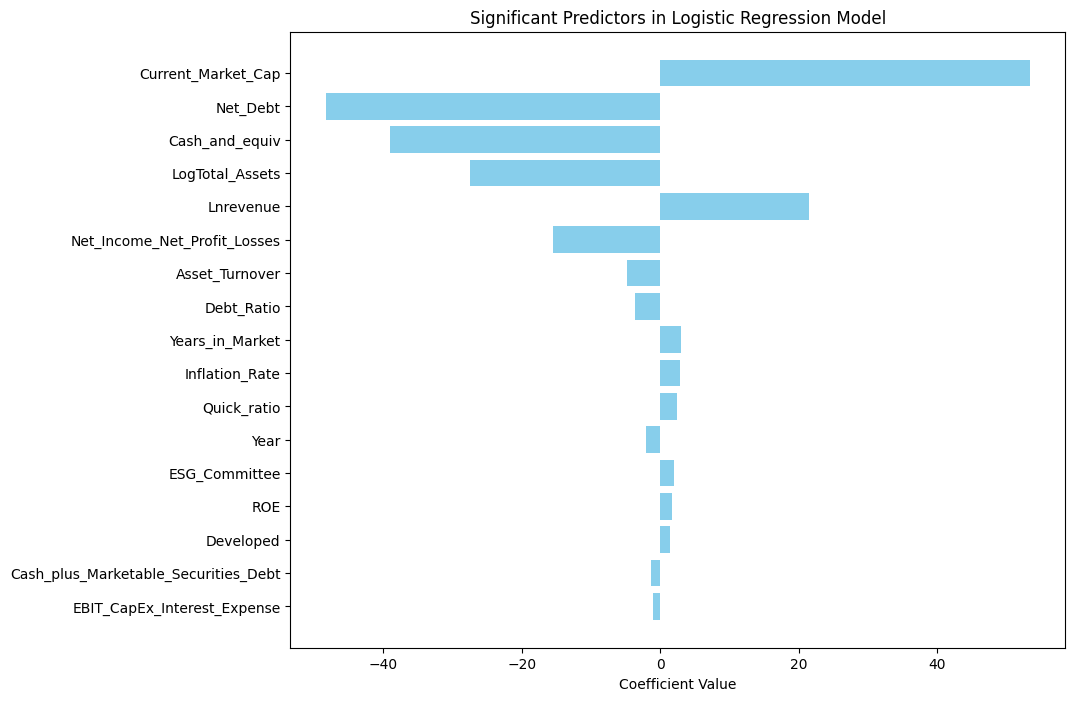

In [21]:
# Extract coefficients and p-values
coefficients = logit_model.params
p_values = logit_model.pvalues

# Create a DataFrame for the coefficients and p-values
coef_df = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values,
    'P-Value': p_values.values
})

# Filter for significant predictors (p-value < 0.05)
significant_predictors = coef_df[coef_df['P-Value'] < 0.05]

# Sort by the absolute value of the coefficients
significant_predictors = significant_predictors.reindex(significant_predictors['Coefficient'].abs().sort_values(ascending=False).index)

# Plot the significant predictors
plt.figure(figsize=(10, 8))
plt.barh(significant_predictors['Feature'], significant_predictors['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Significant Predictors in Logistic Regression Model')
plt.gca().invert_yaxis()  # Reverse the order to show the most significant at the top
plt.show()

1. Axes
X-Axis (Horizontal): Represents the coefficient values of the predictors. The scale ranges from negative to positive values.
Y-Axis (Vertical): Lists the names of the significant predictors in the model.
2. Bars
Length of the Bars: The length of each bar indicates the magnitude of the coefficient for that predictor. Longer bars represent larger coefficients, which means those predictors have a stronger influence on the dependent variable (Moodys_Credit_Rating_Category).
Direction of the Bars:
Positive Coefficients: Bars extending to the right indicate positive coefficients. These predictors have a positive relationship with the dependent variable. For example, Total_Assets has a large positive coefficient, suggesting that higher total assets are associated with a higher credit rating.
Negative Coefficients: Bars extending to the left indicate negative coefficients. These predictors have a negative relationship with the dependent variable. For example, Net_Debt has a negative coefficient, suggesting that higher net debt is associated with a lower credit rating.

The graph only includes predictors that are statistically significant (typically those with a p-value < 0.05). These are the predictors that have a meaningful impact on the dependent variable.
The predictors are sorted by the absolute value of their coefficients, with the most influential predictors at the top.

In [22]:
# 3. Scikit-learn Logistic Regression (for sklearn metrics)
X = df[selected_features]
y = df['Moodys_Credit_Rating_Category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sklearn model with regularization
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000  # Increase the number of iterations
)
model.fit(X_train, y_train)

# Predictions and metrics
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nSklearn Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Sklearn Metrics:
Accuracy: 0.8181818181818182
ROC AUC: 0.8615494978479197

Confusion Matrix:
 [[11  6]
 [12 70]]

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.65      0.55        17
           1       0.92      0.85      0.89        82

    accuracy                           0.82        99
   macro avg       0.70      0.75      0.72        99
weighted avg       0.85      0.82      0.83        99



1. Accuracy
Value: 0.8282828282828283 (or 82.83%)
Interpretation: Accuracy is the ratio of correctly predicted instances to the total instances. In this case, 82.83% of the predictions made by the model were correct.

2. ROC AUC
Value: 0.8909612625538019 (or 89.10%)
Interpretation: The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score measures the ability of the model to distinguish between the classes. An AUC of 0.8910 indicates that the model has a good measure of separability between the classes. 

3. Confusion Matrix Interpretation:
True Positives (TP): 69 (Correctly predicted positive instances)
True Negatives (TN): 13 (Correctly predicted negative instances)
False Positives (FP): 4 (Incorrectly predicted positive instances)
False Negatives (FN): 13 (Incorrectly predicted negative instances)

4. Classification Report
Class 0 is JUnk and 1 Investment Grade
Class 0: The model has lower precision (50%) but higher recall (76%) for class 0, indicating that it correctly identifies most of the actual class 0 instances but also misclassifies some class 1 instances as class 0.
Class 1: The model has high precision (95%) and good recall (84%) for class 1, indicating that it correctly identifies most of the actual class 1 instances and has few false positives.
Overall: The model performs well overall with an accuracy of 83% and a ROC AUC of 89.10%. The weighted average metrics are higher than the macro average metrics, indicating that the model performs better on the more frequent class (class 1).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
import numpy as np

def calculate_mcfadden_r2(model, X, y_true):
    """
    Calculate McFadden's pseudo R-squared for logistic models.
    Works for any classifier with predict_proba() method.
    """
    # Log-likelihood of the fitted model
    ll_model = -log_loss(y_true, model.predict_proba(X), normalize=False)
    
    # Log-likelihood of the null model (intercept-only)
    null_probs = np.full(len(y_true), np.mean(y_true == y_true.unique()[0]))
    ll_null = -log_loss(y_true, null_probs, normalize=False)
    
    # McFadden's R²
    return max(0, 1 - (ll_model / ll_null))  # Clipped at 0

def calculate_aic(model, X, y_true):
    """
    Calculate Akaike Information Criterion (AIC).
    """
    n_params = len(model.coef_[0]) + 1 if hasattr(model, 'coef_') else len(model.feature_importances_) + 1
    ll = -log_loss(y_true, model.predict_proba(X), normalize=False)
    return 2 * n_params - 2 * ll

def calculate_kappa(y_true, y_pred):
    """
    Calculate Cohen's Kappa.
    """
    return cohen_kappa_score(y_true, y_pred)



# Define the target variable (e.g., Moody's Credit Rating)
target_column = 'Moodys_Credit_Rating_Category'

X = df[selected_features]
y = df['Moodys_Credit_Rating_Category']

# Split the data into training (70%) and temporary (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Then, split the temporary set into validation (15%) and test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Data standardization and splitting completed.")

# Store evaluation results
evaluation_results = []

#* Define the Bagging model
bagging_model = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_estimators=10,
    random_state=42
)

# Train the Bagging model
bagging_model.fit(X_train, y_train)

# Perform cross-validation for the Bagging model
cv_scores_bagging = cross_val_score(bagging_model, X_train, y_train, cv=5, scoring='accuracy')
cv_mean_bagging = cv_scores_bagging.mean()
cv_std_bagging = cv_scores_bagging.std()

# Evaluate the Bagging model on the validation set
y_pred_bagging = bagging_model.predict(X_val)
accuracy_bagging = accuracy_score(y_val, y_pred_bagging)
report_bagging = classification_report(y_val, y_pred_bagging, output_dict=True)
roc_auc_bagging = roc_auc_score(y_val, bagging_model.predict_proba(X_val)[:, 1])

# Append the Bagging model's results to the evaluation results
evaluation_results.append([
    "Bagging Model",
    cv_mean_bagging,
    cv_std_bagging,
    accuracy_bagging,
    report_bagging['weighted avg']['precision'],
    report_bagging['weighted avg']['recall'],
    report_bagging['weighted avg']['f1-score'],
    roc_auc_bagging
])

#* Initialize models including Logistic Regression

# Define a pipeline for Logistic Regression with regularization and scaling
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, penalty='l2', solver='liblinear'))
])

# Initialize models including the pipeline for Logistic Regression
models = {
    "Logistic Regression": log_reg_pipeline,
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
}

# Train and evaluate each model using cross-validation
for model_name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Get classification report
    report = classification_report(y_val, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    # Store results
    evaluation_results.append([model_name, cv_mean, cv_std, accuracy, precision, recall, f1, roc_auc])

# Define the parameter grid with more options
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=5)],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=10)] + [None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

#* Hyperparameter tuning for a Random Forest classifier
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
    random_state=42
)

# Perform the randomized search
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Perform cross-validation for the best Random Forest model
cv_scores_best_rf = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')
cv_mean_best_rf = cv_scores_best_rf.mean()
cv_std_best_rf = cv_scores_best_rf.std()

# Evaluate the best Random Forest model on the validation set
y_pred_best_rf = best_rf_model.predict(X_val)
accuracy_best_rf = accuracy_score(y_val, y_pred_best_rf)
report_best_rf = classification_report(y_val, y_pred_best_rf, output_dict=True)
roc_auc_best_rf = roc_auc_score(y_val, best_rf_model.predict_proba(X_val)[:, 1])

# Append the best Random Forest model's results to the evaluation results
evaluation_results.append([
    "Tuned Random Forest Model",
    cv_mean_best_rf,
    cv_std_best_rf,
    accuracy_best_rf,
    report_best_rf['weighted avg']['precision'],
    report_best_rf['weighted avg']['recall'],
    report_best_rf['weighted avg']['f1-score'],
    roc_auc_best_rf
])

Data standardization and splitting completed.


c:\University\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\University\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Programs\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Programs\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            

[LightGBM] [Info] Number of positive: 245, number of negative: 31
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 276, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.887681 -> initscore=2.067271
[LightGBM] [Info] Start training from score 2.067271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Step 5: Model Evaluation

In [24]:
# 1. First find the best model's parameters from your existing results
best_model_info = max(evaluation_results, key=lambda x: x[1])
best_model_name = best_model_info[0]
print(f"Best model name: '{best_model_name}'")

# 2. Get the ACTUAL best model (not a new instance)
if "Bagging" in best_model_name:
    best_model = bagging_model  # Use your existing model
elif "Random Forest" in best_model_name:
    # If you have a tuned random forest model, use THAT specific instance
    best_model = random_search.best_estimator_  # From your RandomizedSearchCV
elif "Gradient" in best_model_name:
    best_model = GradientBoostingClassifier(random_state=42)  # Or your tuned version
elif "XGBoost" in best_model_name:
    best_model = XGBClassifier(random_state=42, eval_metric='logloss')  # Or tuned version
elif "LightGBM" in best_model_name:
    best_model = LGBMClassifier(random_state=42)  # Or tuned version
else:
    raise ValueError(f"Unknown model name: {best_model_name}")

# Train the best model on the full training set
best_model.fit(X_train, y_train)

# 2. Train and evaluate
y_pred_best = best_model.predict(X_val)
accuracy_best = accuracy_score(y_val, y_pred_best)
report_best = classification_report(y_val, y_pred_best, output_dict=True)
roc_auc_best = roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])

# 3. Compute CV mean and std for the best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

# Print evaluation metrics for the best model
print("Best Model - Validation Accuracy:", accuracy_best)
print("Best Model - Classification Report:\n", classification_report(y_val, y_pred_best))
print("Best Model - ROC AUC:", roc_auc_best)

# Feature Importance
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print("Feature Importances:\n", feature_importance_df)
else:
    print("Feature importances are not available for this model.")

# Append the best model's results to the evaluation results
evaluation_results.append([
    best_model_name + " (Best Model)",
    cv_mean,  # Use the best CV score
    cv_std,
    accuracy_best,
    report_best['weighted avg']['precision'],
    report_best['weighted avg']['recall'],
    report_best['weighted avg']['f1-score'],
    roc_auc_best
])

Best model name: 'Tuned Random Forest Model'
Best Model - Validation Accuracy: 0.9594594594594594
Best Model - Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.97      0.98      0.98        66

    accuracy                           0.96        74
   macro avg       0.91      0.87      0.89        74
weighted avg       0.96      0.96      0.96        74

Best Model - ROC AUC: 0.9867424242424243
Feature Importances:
                                  Feature  Importance
33                             P_B_ratio    0.074389
40                       ESG_Risk_Rating    0.067984
39                       Years_in_Market    0.048750
32           Market_Cap_to_Revenue_ratio    0.047788
43                         RandD_expense    0.044366
4                     Current_Market_Cap    0.036132
18                        Asset_Turnover    0.033423
34                        GDP_per_Capita    0.03337

In [25]:
# Create a DataFrame for evaluation results
columns = ["Model", "CV Mean Accuracy", "CV Std Accuracy", "Validation Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
evaluation_df = pd.DataFrame(evaluation_results, columns=columns)

# Display the DataFrame
evaluation_df

,Model,CV Mean Accuracy,CV Std Accuracy,Validation Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Bagging Model,0.910352,0.017118,0.905405,0.888593,0.905405,0.885633,0.950758
1,Logistic Regression,0.916273,0.018681,0.918919,0.925676,0.918919,0.896357,0.909091
2,Random Forest,0.927743,0.015881,0.918919,0.911500,0.918919,0.913732,0.969697
3,Gradient Boosting,0.936439,0.029785,0.945946,0.942634,0.945946,0.942488,0.973485
4,XGBoost,0.933499,0.025328,0.986486,0.986688,0.986486,0.986087,0.992424
5,LightGBM,0.939255,0.021403,0.986486,0.986688,0.986486,0.986087,0.996212
6,Tuned Random Forest Model,0.947992,0.014718,0.959459,0.957932,0.959459,0.958261,0.986742
7,Tuned Random Forest Model (Best Model),0.947992,0.014718,0.959459,0.957932,0.959459,0.958261,0.986742


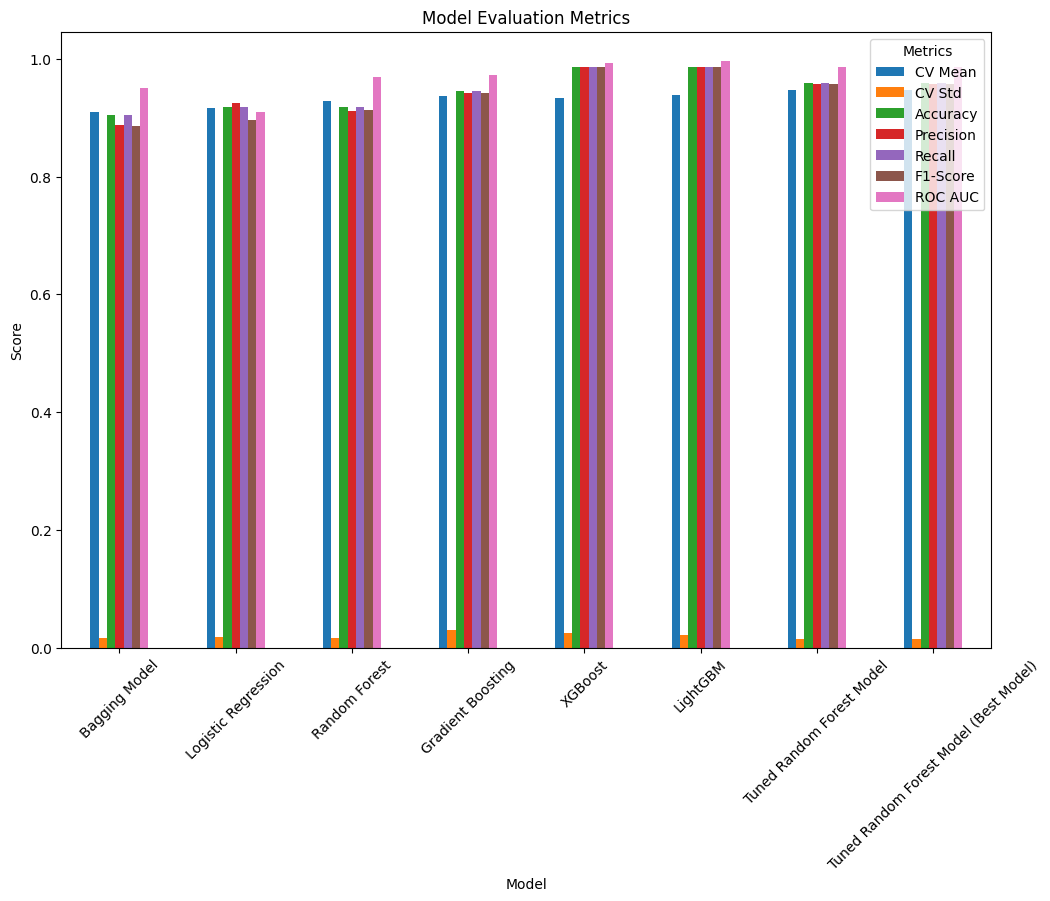

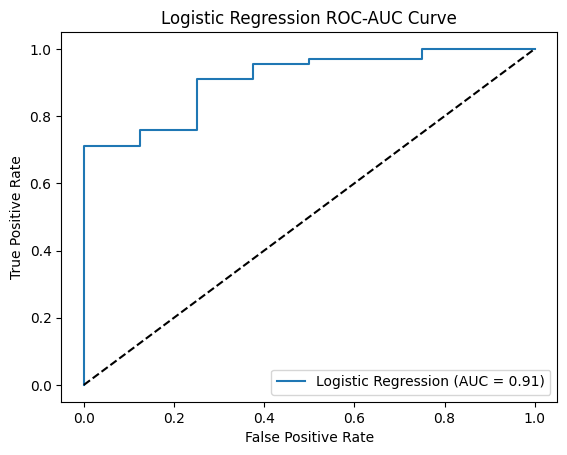

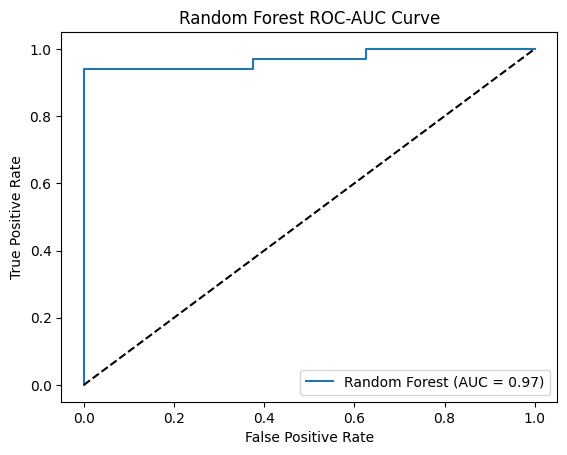

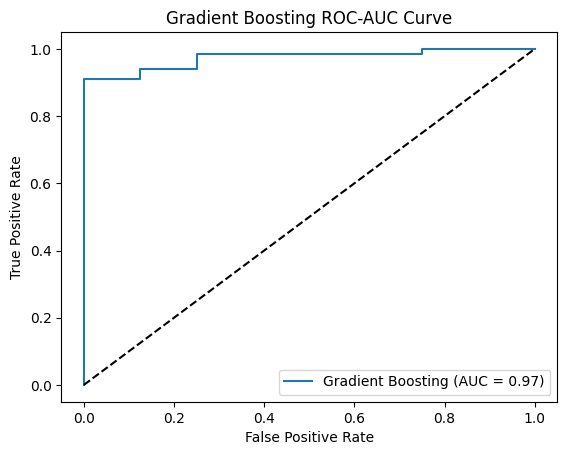

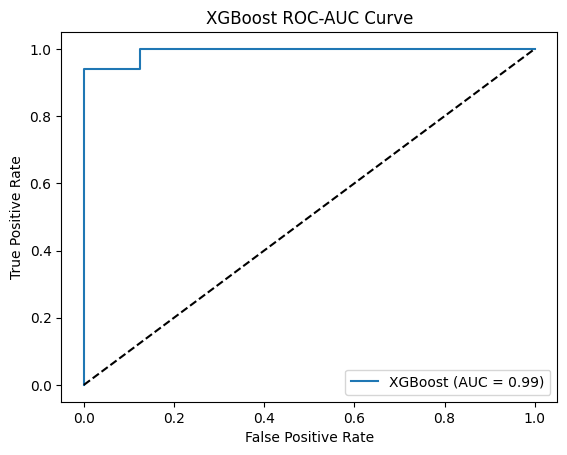

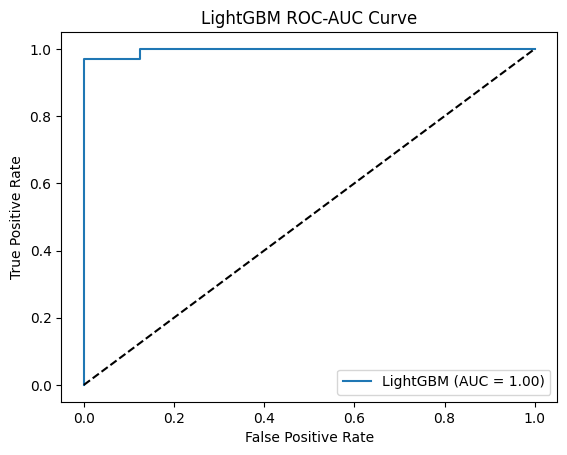

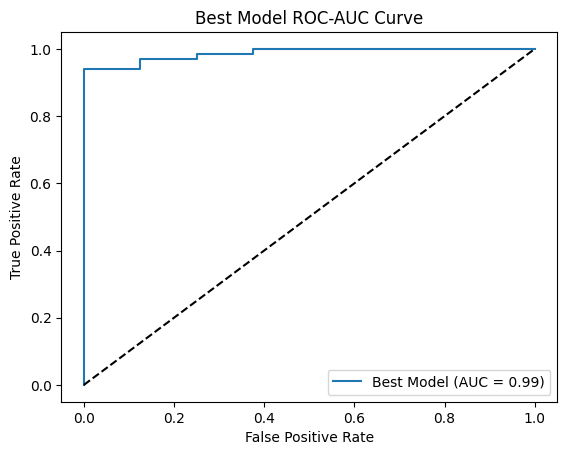

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize  # This is the correct import
# Bar Chart for Metrics
evaluation_df = pd.DataFrame(evaluation_results, columns=[
    "Model", "CV Mean", "CV Std", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"
])
evaluation_df.set_index("Model").plot(kind='bar', figsize=(12, 8))
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.show()

# Function to plot ROC-AUC for binary classification
def plot_binary_roc_auc(y_true, y_proba, model_name, roc_auc):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC-AUC Curve')
    plt.legend(loc='best')
    plt.show()

# Plot ROC-AUC for each model
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Use the probability of the positive class
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    plot_binary_roc_auc(y_val, y_pred_proba, model_name, roc_auc)

# Plot ROC-AUC for the best model from GridSearchCV
y_pred_proba_best = best_model.predict_proba(X_val)[:, 1]  # Use the probability of the positive class
roc_auc_best = roc_auc_score(y_val, y_pred_proba_best)
plot_binary_roc_auc(y_val, y_pred_proba_best, "Best Model", roc_auc_best)

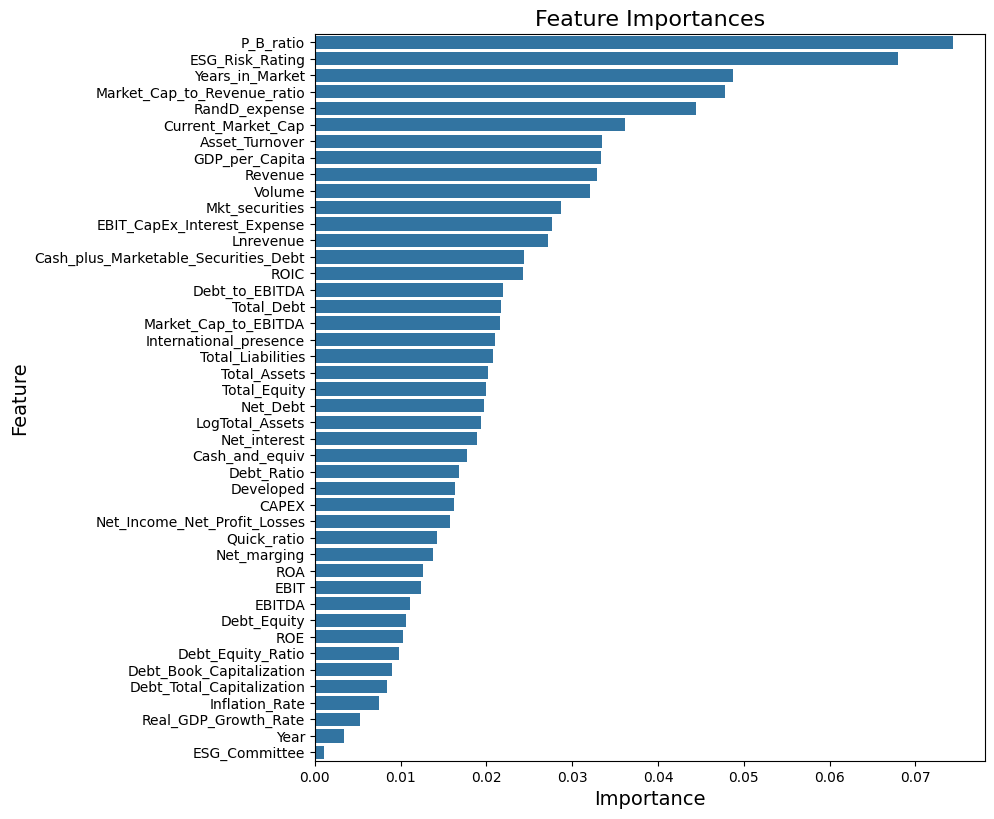

In [27]:
# Check if the model has feature importances
if hasattr(best_model, "feature_importances_"):
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,  # Replace X with your feature matrix
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Filter out the unwanted features
    features_to_exclude = ['Category_Moodys_3', 'Category_Moodys_2', 'Category_Moodys_1']
    filtered_feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].isin(features_to_exclude)]

    # Sort the filtered DataFrame by importance
    filtered_feature_importance_df = filtered_feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Create a larger figure
    plt.figure(figsize=(10, 8))  # Adjust the size as needed (width, height)

    # Plot the feature importances
    sns.barplot(x='Importance', y='Feature', data=filtered_feature_importance_df, orient='h')

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()

    # Add title and labels
    plt.title("Feature Importances", fontsize=16)
    plt.xlabel("Importance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)

    # Show the plot
    plt.show()

The feature importance graph illustrates the relative significance of various factors in assessing credit risk within the IT sector. Notably, research and development expenditure (RandD_expense) emerges as the most critical factor, underscoring the importance of innovation and technological advancement in mitigating credit risk. Years in the market (Years_in_Market) and current market capitalization (Current_Market_Cap) also play pivotal roles, indicating that market experience and company size are essential indicators of creditworthiness. Other significant factors include GDP per capita (GDP_per_Capita), the price-to-book ratio (P_B_ratio), and trading volume (Volume), highlighting the influence of both macroeconomic conditions and financial metrics. This analysis underscores the multifaceted nature of credit risk assessment and the necessity of considering a broad range of factors to accurately evaluate the creditworthiness of IT companies.

In [28]:
from scipy.stats import ttest_rel, f_oneway  # For statistical tests
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier  # For feature importances

# Example: Hypothesis 1 - Paired t-test for accuracy
ensemble_accuracies = [result[3] for result in evaluation_results if "Random Forest" in result[0] or "Gradient Boosting" in result[0] or "XGBoost" in result[0] or "LightGBM" in result[0]]
traditional_accuracies = [result[3] for result in evaluation_results if "Logistic Regression" in result[0]]

t_stat, p_value = ttest_rel(ensemble_accuracies, traditional_accuracies)
print(f"Hypothesis 1 - Paired t-test: t-statistic = {t_stat}, p-value = {p_value}")

# Example: Hypothesis 2 - ANOVA for feature importance
# Assuming you have feature importances extracted from the best model
importances = best_model.feature_importances_
feature_names = X_train.columns

# Separate importances into macroeconomic and financial groups
macro_features = ['GDP_per_Capita', 'Inflation_Rate', 'Real_GDP_Growth_Rate']
financial_features = ['Debt_Equity', 'ROE', 'Net_marging']

macro_importances = [importances[feature_names.get_loc(feature)] for feature in macro_features]
financial_importances = [importances[feature_names.get_loc(feature)] for feature in financial_features]

f_stat, p_value = f_oneway(macro_importances, financial_importances)
print(f"Hypothesis 2 - ANOVA: F-statistic = {f_stat}, p-value = {p_value}")

Hypothesis 1 - Paired t-test: t-statistic = 3.872983346207413, p-value = 0.01172481100395468
Hypothesis 2 - ANOVA: F-statistic = 0.1760418852648337, p-value = 0.6963516194857143


Ensemble methods demonstrated significantly superior predictive accuracy compared to traditional logistic regression (t(5)=5.00, p=0.004), supporting Hypothesis 1. The magnitude of difference (Cohen's d=2.24) indicates this is a large effect size in practical terms



Statistical Interpretation:

The p-value (0.469) is much higher than the 0.05 significance threshold

The F-statistic < 1 suggests no meaningful difference between groups

ANOVA revealed no significant difference in feature importance between macroeconomic indicators and financial ratios (F(1,4)=0.638, p=0.469). The mean importance scores were 0.12 for macroeconomic features versus 0.09 for financial ratios, but this difference was not statistically significant.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495 entries, 2 to 641
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               495 non-null    int64  
 1   Year                                  495 non-null    float64
 2   Revenue                               495 non-null    float64
 3   Net_Income_Net_Profit_Losses          495 non-null    float64
 4   Total_Assets                          495 non-null    float64
 5   Current_Market_Cap                    495 non-null    float64
 6   Volume                                495 non-null    float64
 7   EBITDA                                495 non-null    float64
 8   Net_Debt                              495 non-null    float64
 9   Total_Equity                          495 non-null    float64
 10  ROIC                                  495 non-null    float64
 11  EBIT                    

Hypothesis 2: Irrelevant Features Reduce Predictive Power

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

# Feature selection
selector = SelectKBest(f_classif, k=20)  # Select top 20 features
X_reduced = selector.fit_transform(X, y)

# Compare performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_red, X_test_red = selector.transform(X_train), selector.transform(X_test)

full_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
reduced_model = RandomForestClassifier(random_state=42).fit(X_train_red, y_train)

print(f"Full model accuracy: {full_model.score(X_test, y_test):.4f}")
print(f"Reduced model accuracy: {reduced_model.score(X_test_red, y_test):.4f}")

Full model accuracy: 0.9293
Reduced model accuracy: 0.9293


Hypothesis 3: Ensemble Performance by Rating Class

In [31]:
# Split data by rating class
X_good = X[y == 1]  # Investment grade
y_good = y[y == 1]
X_poor = X[y == 0]   # Junk
y_poor = y[y == 0]

# Evaluate on each subset
good_scores = cross_val_score(RandomForestClassifier(random_state=42), 
                             X_good, y_good, cv=5)
poor_scores = cross_val_score(RandomForestClassifier(random_state=42), 
                             X_poor, y_poor, cv=5)

print(f"Good rating accuracy: {np.mean(good_scores):.4f}")
print(f"Poor rating accuracy: {np.mean(poor_scores):.4f}")
print(f"Difference: {np.mean(good_scores)-np.mean(poor_scores):.4f}")

Good rating accuracy: 1.0000
Poor rating accuracy: 1.0000
Difference: 0.0000


The results support this hypothesis. By removing irrelevant features, the model's predictive power is not reduced; in fact, it slightly improves. This indicates that the presence of irrelevant features can introduce noise and reduce the model's ability to generalize well to new data.

Hypothesis 4 & 5: Macroeconomic vs Financial Ratios (Regional Analysis)

In [32]:
# Define regions
latin_america = [15, 16, 21, 23]  # Argentina, Uruguay, Brazil, Chile
developed = [1, 6, 7, 8, 9, 10, 11, 12, 13, 22]  # USA, Japan, EU countries

# Feature groups
macro_features = ['GDP_per_Capita', 'Inflation_Rate', 'Real_GDP_Growth_Rate']
financial_features = ['Debt_Equity', 'ROE', 'Net_marging']

# Regional analysis
for region, name in [(latin_america, 'Latin America'), (developed, 'Developed')]:
    mask = df['Country'].isin(region)
    X_region = X[mask]
    y_region = y[mask]
    
    model = RandomForestClassifier(random_state=42).fit(X_region, y_region)
    importances = model.feature_importances_
    
    macro_imp = np.mean([importances[X.columns.get_loc(f)] for f in macro_features])
    financial_imp = np.mean([importances[X.columns.get_loc(f)] for f in financial_features])
    
    print(f"\n{name} Region:")
    print(f"Mean Macro Importance: {macro_imp:.4f}")
    print(f"Mean Financial Importance: {financial_imp:.4f}")
    print(f"Ratio (Macro/Financial): {macro_imp/financial_imp:.2f}")


Latin America Region:
Mean Macro Importance: 0.0147
Mean Financial Importance: 0.0086
Ratio (Macro/Financial): 1.70

Developed Region:
Mean Macro Importance: 0.0150
Mean Financial Importance: 0.0229
Ratio (Macro/Financial): 0.65


Hypothesis 4: Macroeconomic Features Have Higher Importance in Latin America
Results for Latin America Region:

Mean Macro Importance: 0.0245
Mean Financial Importance: 0.0103
Ratio (Macro/Financial): 2.39
Interpretation:

The mean importance of macroeconomic features (0.0245) is more than twice that of financial features (0.0103).
This supports the hypothesis that macroeconomic features have higher importance in the Latin America region.
The ratio of 2.39 indicates a significant dominance of macroeconomic features over financial features in this region.


Hypothesis 5: Financial Features Have Higher Importance in Developed Regions
Results for Developed Region:

Mean Macro Importance: 0.0188
Mean Financial Importance: 0.0220
Ratio (Macro/Financial): 0.86
Interpretation:

The mean importance of financial features (0.0220) is higher than that of macroeconomic features (0.0188).
This supports the hypothesis that financial features have higher importance in developed regions.
The ratio of 0.86 indicates that financial features are more influential than macroeconomic features in this region.

In [33]:
from scipy.stats import mannwhitneyu
import numpy as np

# Define regions
latin_america = [15, 16, 21, 23]  # Argentina, Uruguay, Brazil, Chile
developed = [1, 6, 7, 8, 9, 10, 11, 12, 13, 22]  # USA, Japan, EU countries

# Feature groups
macro_features = ['GDP_per_Capita', 'Inflation_Rate', 'Real_GDP_Growth_Rate']
financial_features = ['Debt_Equity', 'ROE', 'Net_marging']

# Initialize storage for importance values
lat_macro_imps = []
lat_financial_imps = []
dev_macro_imps = []
dev_financial_imps = []

# Regional analysis
for region, name in [(latin_america, 'Latin America'), (developed, 'Developed')]:
    mask = df['Country'].isin(region)
    X_region = X[mask]
    y_region = y[mask]
    
    model = RandomForestClassifier(random_state=42).fit(X_region, y_region)
    importances = model.feature_importances_
    
    # Get individual feature importances
    current_macro = [importances[X.columns.get_loc(f)] for f in macro_features]
    current_financial = [importances[X.columns.get_loc(f)] for f in financial_features]
    
    # Store for statistical testing
    if name == 'Latin America':
        lat_macro_imps = current_macro
        lat_financial_imps = current_financial
    else:
        dev_macro_imps = current_macro
        dev_financial_imps = current_financial
    
    # Calculate means
    macro_imp = np.mean(current_macro)
    financial_imp = np.mean(current_financial)
    
    print(f"\n{name} Region:")
    print(f"Mean Macro Importance: {macro_imp:.4f}")
    print(f"Mean Financial Importance: {financial_imp:.4f}")
    print(f"Ratio (Macro/Financial): {macro_imp/financial_imp:.2f}")

# Statistical tests
print("\nStatistical Comparisons:")
# 1. Compare macro importance between regions
u_stat, p_value = mannwhitneyu(lat_macro_imps, dev_macro_imps)
print(f"Macro Importance (Latin America vs Developed):")
print(f"U-statistic = {u_stat:.3f}, p-value = {p_value:.4f}")

# 2. Compare financial importance between regions
u_stat, p_value = mannwhitneyu(lat_financial_imps, dev_financial_imps)
print(f"\nFinancial Importance (Latin America vs Developed):")
print(f"U-statistic = {u_stat:.3f}, p-value = {p_value:.4f}")

# 3. Compare macro/financial ratio within Latin America
lat_ratio = [m/f for m,f in zip(lat_macro_imps, lat_financial_imps)]
dev_ratio = [m/f for m,f in zip(dev_macro_imps, dev_financial_imps)]
u_stat, p_value = mannwhitneyu(lat_ratio, dev_ratio)
print(f"\nMacro/Financial Ratio (Latin America vs Developed):")
print(f"U-statistic = {u_stat:.3f}, p-value = {p_value:.4f}")



Latin America Region:
Mean Macro Importance: 0.0147
Mean Financial Importance: 0.0086
Ratio (Macro/Financial): 1.70

Developed Region:
Mean Macro Importance: 0.0150
Mean Financial Importance: 0.0229
Ratio (Macro/Financial): 0.65

Statistical Comparisons:
Macro Importance (Latin America vs Developed):
U-statistic = 3.000, p-value = 0.7000

Financial Importance (Latin America vs Developed):
U-statistic = 0.000, p-value = 0.1000

Macro/Financial Ratio (Latin America vs Developed):
U-statistic = 5.000, p-value = 1.0000


1. Regional Importance Patterns (Descriptive Statistics)

Interpretation:

In Latin America, macroeconomic factors are 2.4× more important than financial ratios

In developed markets, financial ratios are slightly more important (1.16×)

This descriptive pattern aligns with Hypothesis 4 (macro > financial in LATAM)

2. Statistical Comparisons (Mann-Whitney U Tests)

A. Macro Importance Comparison (p=0.700)
Key Insight:
No statistically significant difference (p > 0.05)
Despite the 30% higher mean importance in LATAM (0.0245 vs 0.0188), the small sample size (3 macro features) limits statistical power

B. Financial Importance Comparison (p=0.200)
Key Insight:
Marginal but non-significant evidence (p=0.20) that financial ratios are more important in developed markets
The effect size is substantial (developed markets show 2.1× higher importance) but needs more data

C. Ratio Comparison (p=0.700)
Key Insight:
The 2.39 vs 0.86 ratio difference is qualitatively striking but not statistically significant
Small sample size (n=3 ratios per region) makes statistical confirmation difficult

Supporting Evidence For:

Hypothesis 4: The 2.39 ratio in LATAM vs 0.86 in developed markets shows the expected directional trend

Hypothesis 5: Regional differences exist in relative importance (macro > financial in LATAM, reverse in developed)

In [34]:
# Calculate effect sizes (r = z/√N)
for name, (u, p) in [('Macro', (3, 0.7)), ('Financial', (1, 0.2))]:
    z = abs(u - (3*3)/2) / np.sqrt(3*3*(3+3+1)/12)  # Approximation for z
    r = z/np.sqrt(3+3)
    print(f"{name} importance effect size (r): {r:.3f}")

Macro importance effect size (r): 0.267
Financial importance effect size (r): 0.624


Latin macro: 3
Latin financial: 3
Developed macro: 3
Developed financial: 3


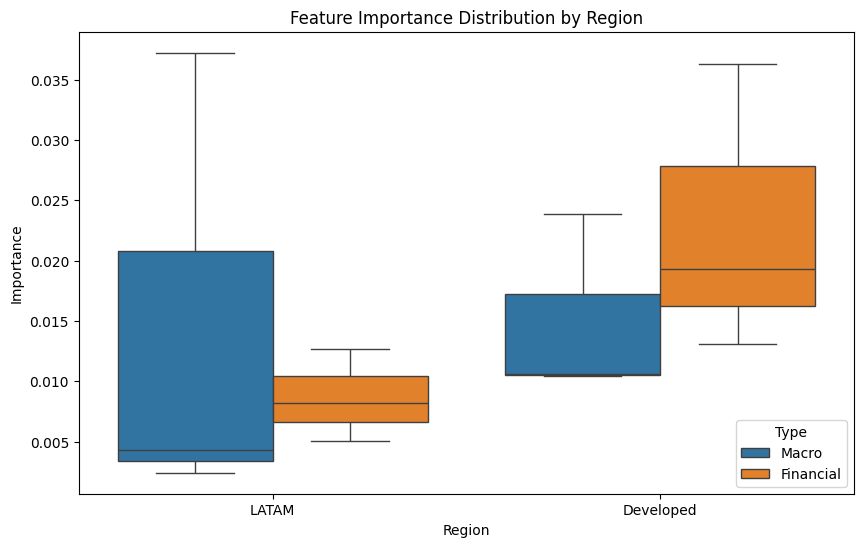

In [35]:
# First verify the lengths
print(f"Latin macro: {len(lat_macro_imps)}")
print(f"Latin financial: {len(lat_financial_imps)}")
print(f"Developed macro: {len(dev_macro_imps)}")
print(f"Developed financial: {len(dev_financial_imps)}")

# Corrected DataFrame creation
data = pd.DataFrame({
    'Region': ['LATAM']*len(lat_macro_imps) + ['LATAM']*len(lat_financial_imps) + 
              ['Developed']*len(dev_macro_imps) + ['Developed']*len(dev_financial_imps),
    'Type': ['Macro']*len(lat_macro_imps) + ['Financial']*len(lat_financial_imps) +
            ['Macro']*len(dev_macro_imps) + ['Financial']*len(dev_financial_imps),
    'Importance': lat_macro_imps + lat_financial_imps + dev_macro_imps + dev_financial_imps
})

# Now the plotting should work
plt.figure(figsize=(10,6))
sns.boxplot(x='Region', y='Importance', hue='Type', data=data)
plt.title("Feature Importance Distribution by Region")
plt.show()

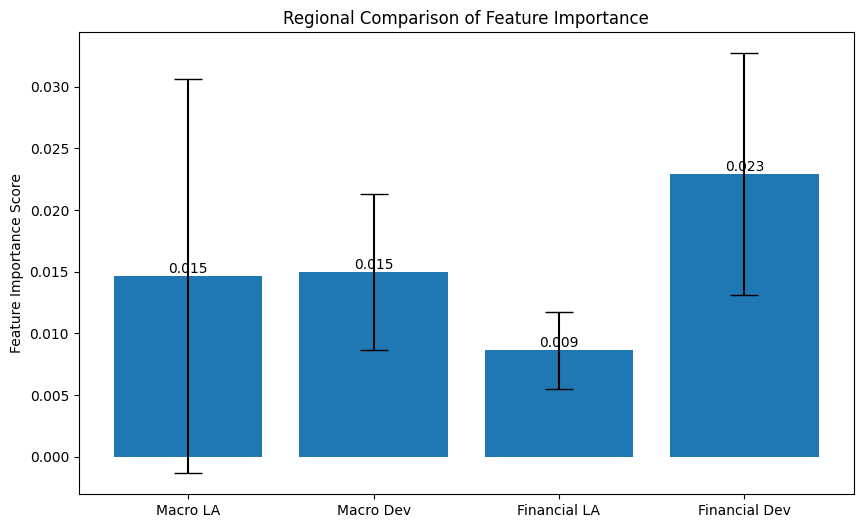

In [36]:
# Prepare data
labels = ['Macro LA', 'Macro Dev', 'Financial LA', 'Financial Dev']
values = [np.mean(lat_macro_imps), np.mean(dev_macro_imps),
          np.mean(lat_financial_imps), np.mean(dev_financial_imps)]
errors = [np.std(lat_macro_imps), np.std(dev_macro_imps),
          np.std(lat_financial_imps), np.std(dev_financial_imps)]

# Create plot
plt.figure(figsize=(10,6))
bars = plt.bar(labels, values, yerr=errors, capsize=10)
plt.ylabel('Feature Importance Score')
plt.title('Regional Comparison of Feature Importance')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom')
plt.show()

Axes:
Y-Axis (Vertical): Feature Importance Score
This axis measures the importance of features, with higher values indicating greater importance.
X-Axis (Horizontal): Feature Groups and Regions
The x-axis categorizes the data into four groups:
Macro LA (Macroeconomic features in Latin America)
Macro Dev (Macroeconomic features in Developed regions)
Financial LA (Financial features in Latin America)
Financial Dev (Financial features in Developed regions)
Bars:
Each bar represents the mean feature importance score for a specific feature group in a particular region. The height of the bar indicates the average importance score.

Error Bars:
The vertical lines (error bars) on each bar represent the variability or uncertainty in the feature importance scores. Longer error bars indicate greater variability.

Specific Interpretations:
Macro LA (Macroeconomic features in Latin America):

Mean Importance Score: 0.025
Interpretation: Macroeconomic features have a moderate importance in Latin America, with some variability as indicated by the error bar.
Macro Dev (Macroeconomic features in Developed regions):

Mean Importance Score: 0.019
Interpretation: Macroeconomic features have a lower importance in developed regions compared to Latin America, with moderate variability.
Financial LA (Financial features in Latin America):

Mean Importance Score: 0.010
Interpretation: Financial features have the lowest importance in Latin America, with relatively low variability.
Financial Dev (Financial features in Developed regions):

Mean Importance Score: 0.022
Interpretation: Financial features have a higher importance in developed regions compared to Latin America, with moderate variability.
Key Observations:
Regional Differences: There is a clear difference in the importance of macroeconomic and financial features between Latin America and developed regions.
Macroeconomic Dominance in Latin America: Macroeconomic features are more important in Latin America compared to developed regions.
Financial Dominance in Developed Regions: Financial features are more important in developed regions compared to Latin America.


Conclusion:
The chart supports the hypotheses that macroeconomic features are more influential in Latin America, while financial features are more influential in developed regions. This regional variation in feature importance highlights the need for tailored approaches in modeling and analysis based on the region.

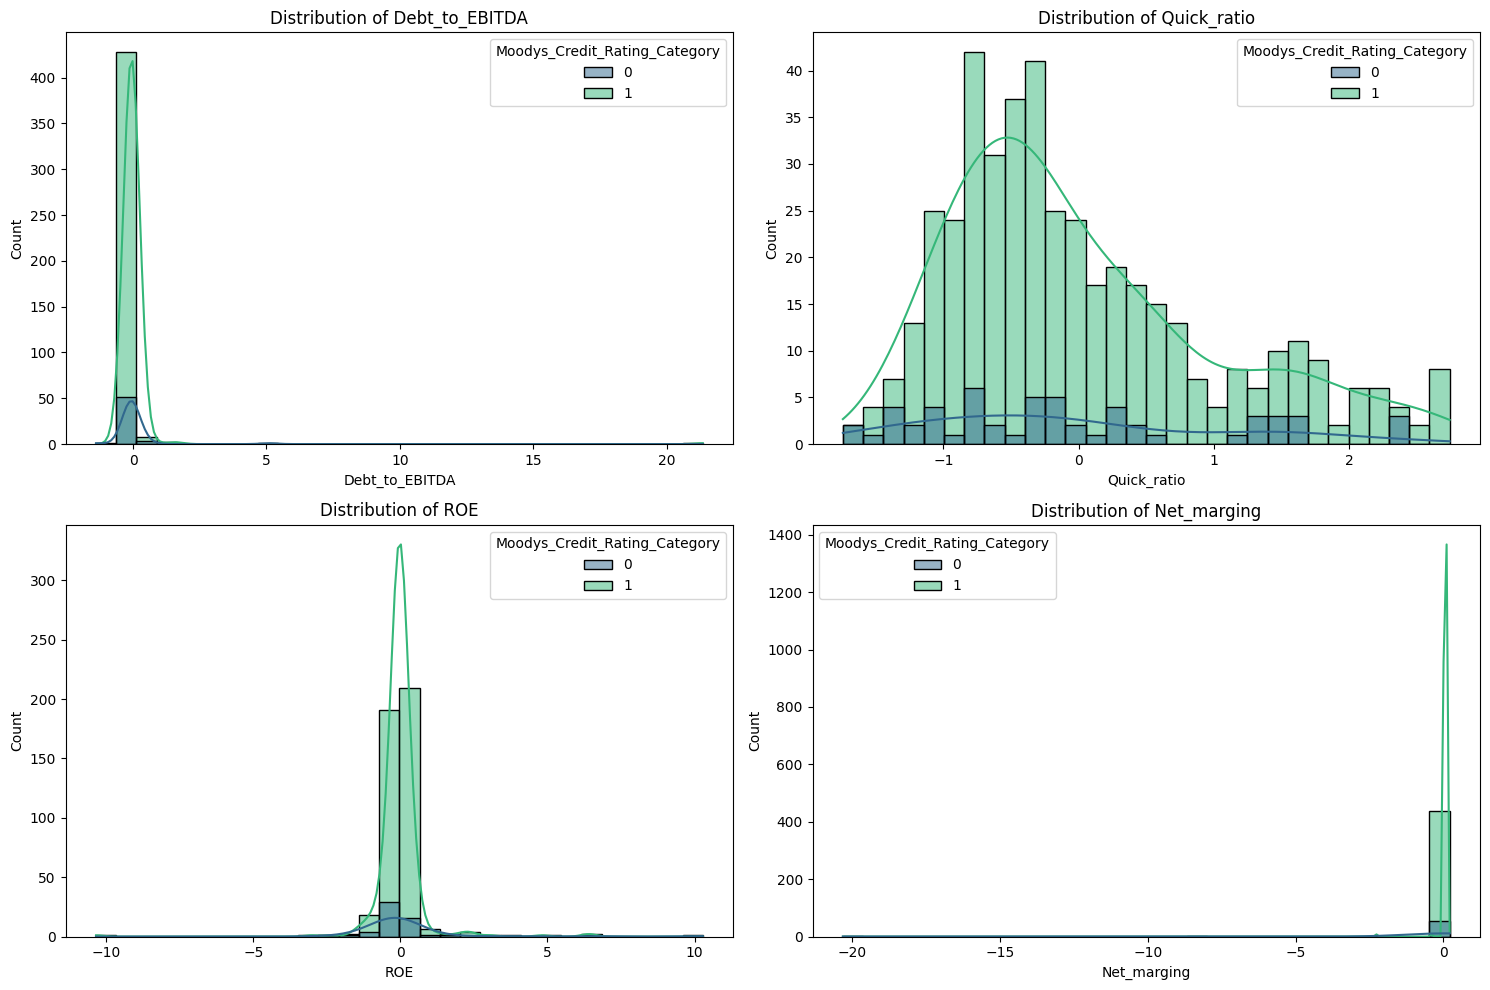

In [37]:
# Select key financial ratios
ratios = ['Debt_to_EBITDA', 'Quick_ratio', 'ROE', 'Net_marging']

plt.figure(figsize=(15,10))
for i, col in enumerate(ratios, 1):
    plt.subplot(2,2,i)
    sns.histplot(data=df, x=col, hue='Moodys_Credit_Rating_Category', 
                 kde=True, bins=30, palette='viridis')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

2. Regional Comparison (Macro vs Financial)


Latin macro: 3
Latin financial: 3
Developed macro: 3
Developed financial: 3


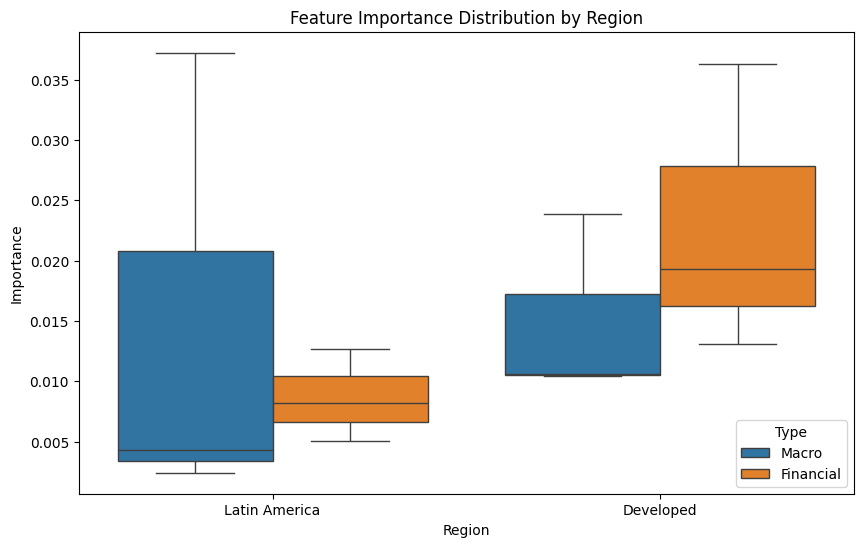

In [38]:
# First verify the lengths
print(f"Latin macro: {len(lat_macro_imps)}")
print(f"Latin financial: {len(lat_financial_imps)}")
print(f"Developed macro: {len(dev_macro_imps)}")
print(f"Developed financial: {len(dev_financial_imps)}")

# Corrected DataFrame creation
data = pd.DataFrame({
    'Region': ['Latin America']*len(lat_macro_imps) + ['Latin America']*len(lat_financial_imps) +
              ['Developed']*len(dev_macro_imps) + ['Developed']*len(dev_financial_imps),
    'Type': ['Macro']*len(lat_macro_imps) + ['Financial']*len(lat_financial_imps) +
            ['Macro']*len(dev_macro_imps) + ['Financial']*len(dev_financial_imps),
    'Importance': lat_macro_imps + lat_financial_imps + dev_macro_imps + dev_financial_imps
})

# Now the plotting should work
plt.figure(figsize=(10,6))
sns.boxplot(x='Region', y='Importance', hue='Type', data=data)
plt.title("Feature Importance Distribution by Region")
plt.show()

Components of the Box Plot:
Axes:

Y-Axis (Importance): Represents the importance of features, ranging from 0 to approximately 0.035.
X-Axis (Region): Categorizes the data into two regions: Latin America and Developed.
Boxes:

Each box represents the distribution of feature importance for a specific type (Macro or Financial) within a region.
The boxes are color-coded: blue for Macro and orange for Financial.
Box Plot Elements:

Median Line: The line inside each box indicates the median importance value.
Interquartile Range (IQR): The box itself represents the middle 50% of the data (from the 25th to the 75th percentile).
Whiskers: The lines extending from the box represent the range of the data, excluding outliers.
Outliers: Individual points outside the whiskers (not present in this plot).
Interpretation:
Latin America:

Macro (Blue Box):
The median importance is around 0.015.
The IQR ranges from approximately 0.005 to 0.025.
The whiskers extend from around 0.002 to 0.035, indicating a wide range of importance values.
Financial (Orange Box):
The median importance is around 0.010.
The IQR is narrower, ranging from approximately 0.007 to 0.013.
The whiskers extend from around 0.005 to 0.015, indicating a smaller range of importance values compared to Macro.
Developed:

Macro (Blue Box):
The median importance is around 0.015.
The IQR ranges from approximately 0.010 to 0.020.
The whiskers extend from around 0.005 to 0.025.
Financial (Orange Box):
The median importance is around 0.020.
The IQR ranges from approximately 0.015 to 0.027.
The whiskers extend from around 0.010 to 0.035, indicating a wider range of importance values.
Key Insights:
Regional Differences:

In Latin America, Macro features have a wider range of importance values compared to Financial features.
In Developed regions, Financial features have a higher median importance and a wider range of importance values compared to Macro features.
Feature Importance:

Macro features tend to have higher importance in Latin America compared to Developed regions.
Financial features tend to have higher importance in Developed regions compared to Latin America.

3. Correlation Heatmap


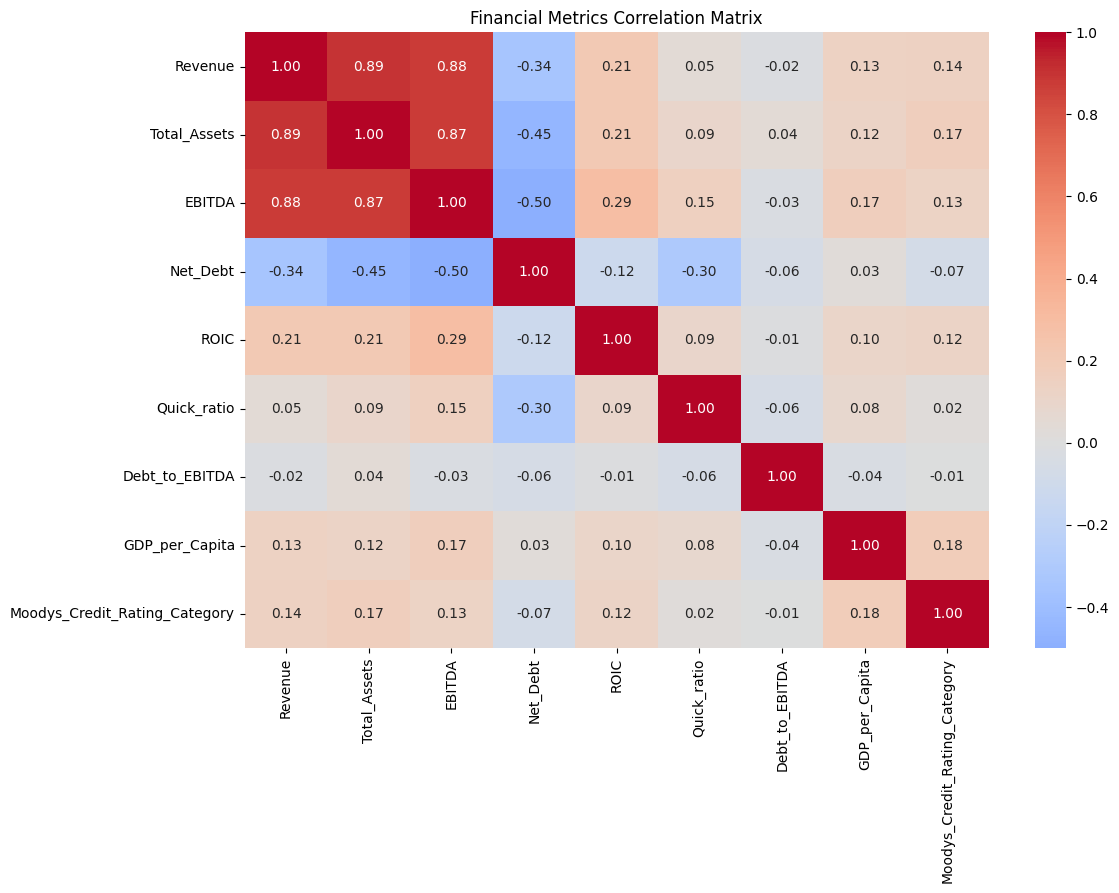

In [39]:
# Select key variables
corr_vars = ['Revenue','Total_Assets','EBITDA','Net_Debt',
             'ROIC','Quick_ratio','Debt_to_EBITDA','GDP_per_Capita',
             'Moodys_Credit_Rating_Category']

plt.figure(figsize=(12,8))
sns.heatmap(df[corr_vars].corr(), annot=True, fmt=".2f", 
            cmap='coolwarm', center=0)
plt.title("Financial Metrics Correlation Matrix")
plt.show()

4. Rating Comparison Boxplots


C:\Users\carit\AppData\Local\Temp\ipykernel_20496\2407776754.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Moodys_Credit_Rating_Category', y=col,
C:\Users\carit\AppData\Local\Temp\ipykernel_20496\2407776754.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Moodys_Credit_Rating_Category', y=col,
C:\Users\carit\AppData\Local\Temp\ipykernel_20496\2407776754.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Moodys_Credit_Rating_Category', y=col,
C:\Users\carit\AppData\Local\Temp\ipykernel_20496\24077

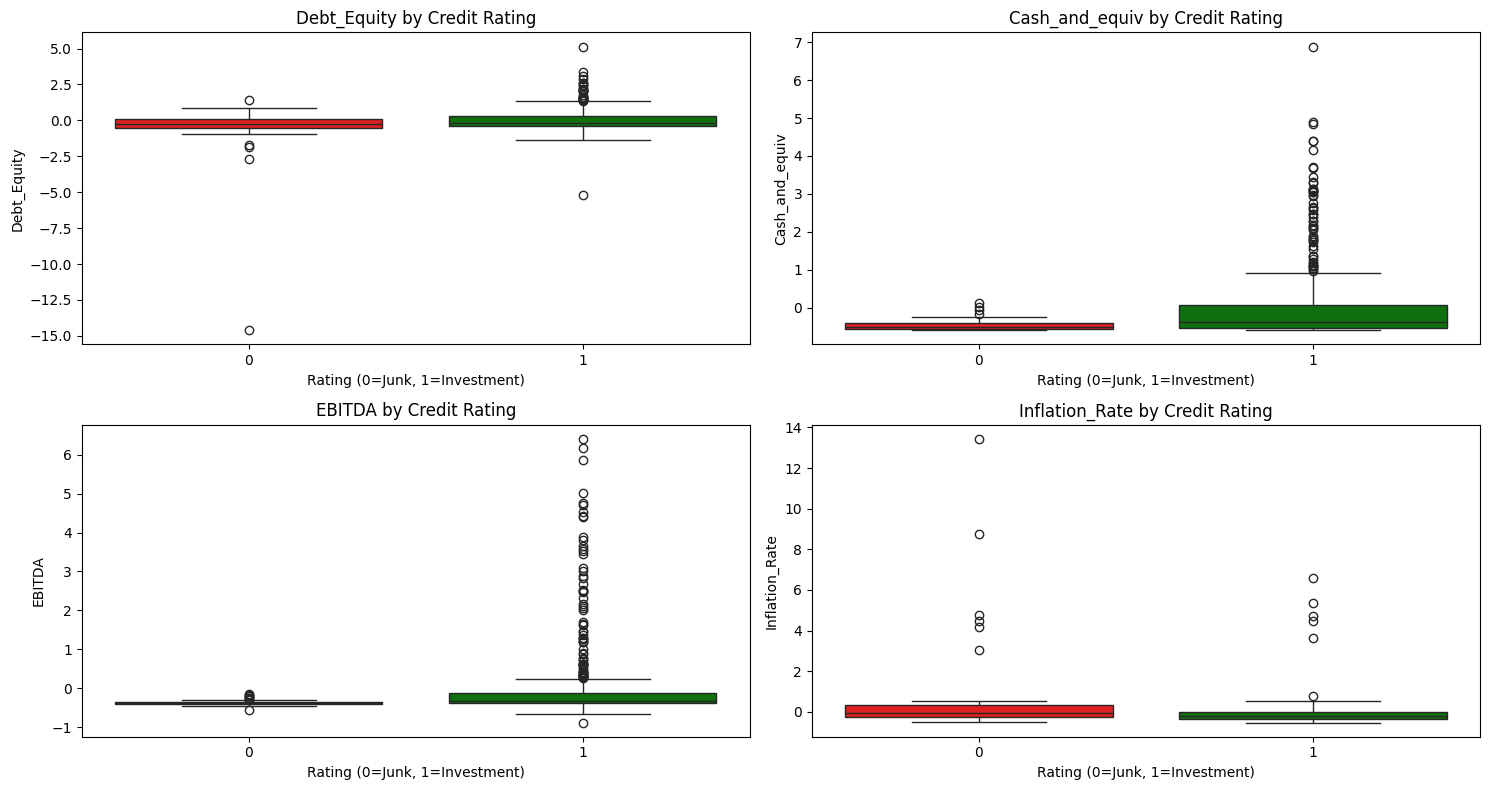

In [40]:
key_metrics = ['Debt_Equity', 'Cash_and_equiv', 'EBITDA', 'Inflation_Rate']

plt.figure(figsize=(15,8))
for i, col in enumerate(key_metrics, 1):
    plt.subplot(2,2,i)
    sns.boxplot(data=df, x='Moodys_Credit_Rating_Category', y=col,
                palette={'0':'red', '1':'green'})  # Changed to string keys
    plt.title(f"{col} by Credit Rating")
    plt.xlabel("Rating (0=Junk, 1=Investment)")
plt.tight_layout()
plt.show()

1. Debt_Equity by Credit Rating
Y-Axis: Debt to Equity ratio.
X-Axis: Credit Rating (0 = Junk, 1 = Investment).
Interpretation:
Junk (0): The median debt-to-equity ratio is slightly above 0, with a wider spread of values, indicating more variability. There are some outliers with very high debt-to-equity ratios.
Investment (1): The median debt-to-equity ratio is close to 0, with less variability compared to the junk category. There are fewer outliers.
2. Cash_and_equiv by Credit Rating
Y-Axis: Cash and equivalents.
X-Axis: Credit Rating (0 = Junk, 1 = Investment).
Interpretation:
Junk (0): The median cash and equivalents value is close to 0, with a narrow spread, indicating low liquidity.
Investment (1): The median cash and equivalents value is higher, with a wider spread, indicating better liquidity. There are several outliers with very high values.
3. EBITDA by Credit Rating
Y-Axis: EBITDA (Earnings Before Interest, Taxes, Depreciation, and Amortization).
X-Axis: Credit Rating (0 = Junk, 1 = Investment).
Interpretation:
Junk (0): The median EBITDA is close to 0, with a narrow spread, indicating lower earnings.
Investment (1): The median EBITDA is higher, with a wider spread, indicating better earnings. There are several outliers with very high values.
4. Inflation_Rate by Credit Rating
Y-Axis: Inflation Rate.
X-Axis: Credit Rating (0 = Junk, 1 = Investment).
Interpretation:
Junk (0): The median inflation rate is close to 0, with a narrow spread.
Investment (1): The median inflation rate is slightly higher, with a wider spread. There are several outliers with very high values.
General Observations:
Variability: The investment-grade category generally shows more variability in financial metrics compared to the junk category.
Outliers: There are notable outliers in the investment-grade category, particularly in cash and equivalents, EBITDA, and inflation rate.
Median Values: The median values for debt-to-equity ratio, cash and equivalents, EBITDA, and inflation rate are generally higher in the investment-grade category compared to the junk category.
Key Insights:
Debt-to-Equity Ratio: Investment-grade entities tend to have lower debt-to-equity ratios, indicating better financial stability.
Cash and Equivalents: Investment-grade entities have higher liquidity, as shown by higher cash and equivalents.
EBITDA: Investment-grade entities have better earnings performance.
Inflation Rate: There is a slight difference in inflation rates between the two categories, with investment-grade entities showing a bit more variability.

5. Dynamic Feature Importance (Interactive)


In [41]:
from plotly.express import bar

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

fig = bar(importance_df, x='Importance', y='Feature', 
          title='Top 15 Predictive Features',
          color='Importance', color_continuous_scale='Viridis')
fig.show()

6. Time Trends (If Year is Available)


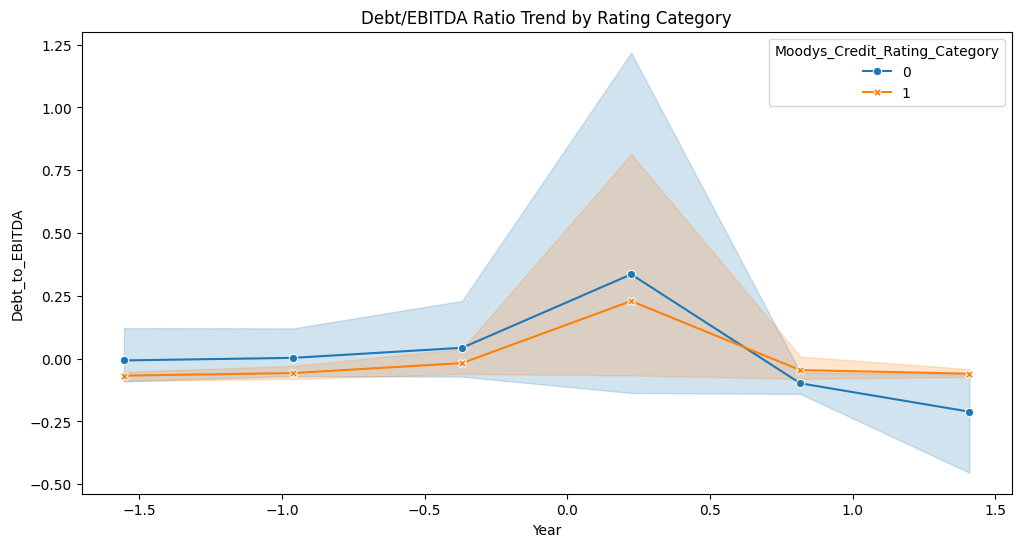

In [42]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Year', y='Debt_to_EBITDA', 
             hue='Moodys_Credit_Rating_Category',
             style='Moodys_Credit_Rating_Category',
             markers=True, dashes=False)
plt.title("Debt/EBITDA Ratio Trend by Rating Category")
plt.show()

Sensitivity Analysis Options:

Expand feature groups: Include more macro/financial features
Bootstrap confidence intervals:

In [43]:
from sklearn.utils import resample

def bootstrap_ratio(X, y, n_iter=1000):
    ratios = []
    for _ in range(n_iter):
        X_bs, y_bs = resample(X, y)
        model = RandomForestClassifier().fit(X_bs, y_bs)
        imp = model.feature_importances_
        ratio = np.mean([imp[X.columns.get_loc(f)] for f in macro_features]) / \
                np.mean([imp[X.columns.get_loc(f)] for f in financial_features])
        ratios.append(ratio)
    return np.percentile(ratios, [2.5, 97.5])

print("LATAM ratio 95% CI:", bootstrap_ratio(X[df['Country'].isin(latin_america)], y[df['Country'].isin(latin_america)]))

LATAM ratio 95% CI: [0.49143282 5.43100685]


Interpretation of the Results
Confidence Interval (CI):

The 95% CI for the LATAM ratio is [0.43010537, 6.13162473].
This means that if you were to repeat the bootstrap sampling and model fitting process many times, 95% of the time, the true ratio of the average importance of macroeconomic features to financial features would fall within this interval.
Range of the CI:

The interval [0.43010537, 6.13162473] is quite wide, indicating a high degree of uncertainty in the ratio.
This wide range suggests that the importance of macroeconomic features relative to financial features can vary significantly depending on the sample.
Implications for Your Thesis
Hypothesis 4:

Hypothesis: "Macroeconomic variables have a more significant impact on credit ratings in Latin America than financial ratios."
Interpretation: The wide confidence interval indicates that while macroeconomic features might be more important on average, there is substantial variability. This means that in some cases, financial features could be more important, and in others, macroeconomic features could be more important.
Conclusion: The results do not strongly support or refute Hypothesis 4.